In [57]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
df_list = []
mask_list = []
label_list = []

for reff_multi in [1,2]:
    with open(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle', 'rb') as f:
        data_plot, masks, labels = pickle.load(f)
        df = pd.DataFrame(data_plot)
        df_list.append(df)
        mask_list.append(masks)
        label_list.append(labels)


In [ ]:
df_list[1]

In [72]:
df = df_list[1]
masks = mask_list[1]
#append mask for all galaxies
masks['All'] = np.ones(len(df), dtype=bool)

T_diff = df['T_d'] - df['T_s']
#get average values for each shape parameter, for each mask


for mask in masks.keys():
    print(f"\nAverage values for mask: {mask}, n = {np.sum(masks[mask])}")
    #for columns B_s, C_s, T_s, B_d, C_d, T_d
    B_s = df.loc[masks[mask], 'B_s']
    C_s = df.loc[masks[mask], 'C_s']
    T_s = df.loc[masks[mask], 'T_s']
    B_d = df.loc[masks[mask], 'B_d']
    C_d = df.loc[masks[mask], 'C_d']
    T_d = df.loc[masks[mask], 'T_d']
    #print average values
    print(f"B_s: {B_s.mean():.2f}, C_s: {C_s.mean():.2f}, T_s: {T_s.mean():.2f}, B_d: {B_d.mean():.2f}, C_d: {C_d.mean():.2f}, T_d: {T_d.mean():.2f}")
    #print differnce between _s and _d
    print(f"B_s - B_d: {(B_s - B_d).mean():.2f}, C_s - C_d: {(C_s - C_d).mean():.2f}, T_s - T_d: {(T_s - T_d).mean():.2f}")
    #print ratio of _s to _d
    print(f"B_s/B_d: {(B_s/B_d).mean():.2f}, C_s/C_d: {(C_s/C_d).mean():.2f}, T_s/T_d: {(T_s/T_d).mean():.2f}")

    #what is the count of galaxies in each mask above mass 7.5
    print(f"Number of galaxies with mass > 7.5: {np.sum(df.loc[masks[mask], 'masses'] < 7.5)}")

    #print standard deviation of each shape parameter
    print(f"Standard deviation of B_s: {B_s.std():.2f}, C_s: {C_s.std():.2f}, T_s: {T_s.std():.2f}, B_d: {B_d.std():.2f}, C_d: {C_d.std():.2f}, T_d: {T_d.std():.2f}")

    #print number of galaxies with abs(T_diff) < 1/6
    print(f"Number of galaxies with abs(T_diff) < 1/6: {np.sum(np.abs(T_diff[masks[mask]]) < 0.15)}")




Average values for mask: non-disky, n = 46
B_s: 0.76, C_s: 0.54, T_s: 0.56, B_d: 0.80, C_d: 0.64, T_d: 0.57
B_s - B_d: -0.04, C_s - C_d: -0.10, T_s - T_d: -0.01
B_s/B_d: 0.95, C_s/C_d: 0.85, T_s/T_d: 0.98
Number of galaxies with mass > 7.5: 18
Standard deviation of B_s: 0.15, C_s: 0.13, T_s: 0.27, B_d: 0.13, C_d: 0.14, T_d: 0.24
Number of galaxies with abs(T_diff) < 1/6: 37

Average values for mask: disky, n = 34
B_s: 0.85, C_s: 0.26, T_s: 0.29, B_d: 0.93, C_d: 0.57, T_d: 0.20
B_s - B_d: -0.08, C_s - C_d: -0.31, T_s - T_d: 0.09
B_s/B_d: 0.92, C_s/C_d: 0.47, T_s/T_d: 1.78
Number of galaxies with mass > 7.5: 1
Standard deviation of B_s: 0.08, C_s: 0.06, T_s: 0.14, B_d: 0.05, C_d: 0.07, T_d: 0.13
Number of galaxies with abs(T_diff) < 1/6: 23

Average values for mask: All, n = 80
B_s: 0.80, C_s: 0.42, T_s: 0.45, B_d: 0.85, C_d: 0.61, T_d: 0.42
B_s - B_d: -0.05, C_s - C_d: -0.19, T_s - T_d: 0.03
B_s/B_d: 0.94, C_s/C_d: 0.69, T_s/T_d: 1.32
Number of galaxies with mass > 7.5: 19
Standard dev

In [73]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression

def analyze_galaxy_parameters(df, masks, parameters=None):
    """
    Analyze galaxy parameters across different masks.
    
    Args:
        df: DataFrame containing galaxy data
        masks: Dictionary of boolean masks
        parameters: List of parameter pairs to analyze (default: all '_s' and '_d' pairs)
    """
    # If no parameters specified, find all pairs of parameters ending in '_s' and '_d'
    if parameters is None:
        parameters = []
        for col in df.columns:
            if col.endswith('_s'):
                base = col[:-2]
                if f"{base}_d" in df.columns:
                    parameters.append(base)
    
    # Add mask for all galaxies if not present
    if 'All' not in masks:
        masks['All'] = np.ones(len(df), dtype=bool)
    
    results = {}
    
    for mask_name, mask in masks.items():
        n_galaxies = np.sum(mask)
        results[mask_name] = {
            'n_galaxies': n_galaxies,
            'parameters': {}
        }
        
        print(f"\n{'='*80}")
        print(f"Analysis for mask: {mask_name} (n = {n_galaxies})")
        print(f"{'='*80}")
        
        # Parameter statistics
        print("\n1. Parameter Statistics:")
        print(f"{'Parameter':<10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
        print("-" * 50)
        
        for param in parameters:
            suffix_s = f"{param}_s"
            suffix_d = f"{param}_d"
            
            data_s = df.loc[mask, suffix_s]
            data_d = df.loc[mask, suffix_d]
            
            # Store statistics
            param_stats = {
                'mean': {'s': data_s.mean(), 'd': data_d.mean()},
                'std': {'s': data_s.std(), 'd': data_d.std()},
                'min': {'s': data_s.min(), 'd': data_d.min()},
                'max': {'s': data_s.max(), 'd': data_d.max()},
                'difference': (data_s - data_d).mean(),
                'ratio': (data_s / data_d).mean()
            }
            results[mask_name]['parameters'][param] = param_stats
            
            # Print statistics
            print(f"{param}_s{'':<3} {data_s.mean():10.2f} {data_s.std():10.2f} {data_s.min():10.2f} {data_s.max():10.2f}")
            print(f"{param}_d{'':<3} {data_d.mean():10.2f} {data_d.std():10.2f} {data_d.min():10.2f} {data_d.max():10.2f}")
        

        
        # how many values of B and C lie near the line C = (B - 0.15) ± 0.15
        B_s = df.loc[mask, 'B_s']
        C_s = df.loc[mask, 'C_s']
        B_d = df.loc[mask, 'B_d']
        C_d = df.loc[mask, 'C_d']
        
        tol = 0.15  # Remove the extra 0. and period
        # For stellar components
        stellar_count = ((B_s - 0.15 - tol <= C_s) & (C_s <= B_s - 0.15 + tol)).sum()
        
        # For dark matter components
        dark_matter_count = ((B_d - 0.15 - tol <= C_d) & (C_d <= B_d - 0.15 + tol)).sum()
        
        print(f"\nNumber of stellar component points on the line S = (Q - 0.15) ± 0.15: {stellar_count}")
        print(f"Number of dark matter component points on the line S = (Q - 0.15) ± 0.15: {dark_matter_count}")
        
        
        # Mass analysis
        print("\n2. Mass Distribution:")
        masses = df.loc[mask, 'masses']
        print(f"Galaxies with mass < 7.5: {np.sum(masses < 7.5)}")
        print(f"Mass range: {masses.min():.2f} to {masses.max():.2f}")
        
        # Temperature difference analysis
        T_diff = df.loc[mask, 'T_s'] - df.loc[mask, 'T_d']
        print(f"\n3. Triaxiality Analysis:")
        print(f"Galaxies with |T_diff| < 1/6: {np.sum(np.abs(T_diff) < 0.15)}")
        print(f"T_diff range: {T_diff.min():.2f} to {T_diff.max():.2f}")
        
        # Linear regression analysis
        print("\n4. Linear Regression Analysis:")
        
        # Function to perform and print regression results
        def analyze_regression(X, y, label):
            X_reshaped = X.reshape(-1, 1)
            reg = LinearRegression().fit(X_reshaped, y)
            r_squared = reg.score(X_reshaped, y)
            slope = reg.coef_[0]
            intercept = reg.intercept_
            
            # Calculate residuals and their standard deviation
            y_pred = reg.predict(X_reshaped)
            residuals = y - y_pred
            residual_std = np.std(residuals)
            
            print(f"\n{label}:")
            print(f"R² = {r_squared:.3f}")
            print(f"Slope = {slope:.3f}")
            print(f"Intercept = {intercept:.3f}")
            print(f"Residual Std = {residual_std:.3f}")
            
            #plot regression line, data, and shaded region of residuals
            # plt.figure(figsize=(10, 6))
            # plt.scatter(X, y, label='Data')
            # plt.plot(X, y_pred, color='red', label='Regression Line')
            # plt.fill_between(X, y_pred - residual_std, y_pred + residual_std, color='gray', alpha=0.5, label='Residuals')
            # plt.xlabel('X')
            # plt.ylabel('y')
            # plt.legend()
            # plt.show()
            
            
            return {
                'r_squared': r_squared,
                'slope': slope,
                'intercept': intercept,
                'residual_std': residual_std
            }
        
        # Analyze C_s vs masses
        results[mask_name]['regression_C_s'] = analyze_regression(
            df.loc[mask, 'masses'].values,
            df.loc[mask, 'C_s'].values,            
            "masses vs C_s"
        )
        
        # Analyze C_s/C_d vs masses
        C_ratio = df.loc[mask, 'C_s'].values / df.loc[mask, 'C_d'].values
        results[mask_name]['regression_C_ratio'] = analyze_regression(
            df.loc[mask, 'masses'].values,
            C_ratio,            
            "masses vs C_s/C_d"
        )
    
    return results

# Example usage:
results = analyze_galaxy_parameters(df_list[1], mask_list[1])


Analysis for mask: non-disky (n = 46)

1. Parameter Statistics:
Parameter        Mean        Std        Min        Max
--------------------------------------------------
B_s          0.76       0.15       0.47       0.98
B_d          0.80       0.13       0.56       0.97
C_s          0.54       0.13       0.34       0.88
C_d          0.64       0.14       0.45       0.89
T_s          0.56       0.27       0.06       0.93
T_d          0.57       0.24       0.17       0.91

Number of stellar component points on the line S = (Q - 0.15) ± 0.15: 35
Number of dark matter component points on the line S = (Q - 0.15) ± 0.15: 41

2. Mass Distribution:
Galaxies with mass < 7.5: 18
Mass range: 6.17 to 9.47

3. Triaxiality Analysis:
Galaxies with |T_diff| < 1/6: 37
T_diff range: -0.31 to 0.35

4. Linear Regression Analysis:

masses vs C_s:
R² = 0.089
Slope = -0.043
Intercept = 0.880
Residual Std = 0.126

masses vs C_s/C_d:
R² = 0.356
Slope = -0.078
Intercept = 1.462
Residual Std = 0.096

Analysis 


Average values for mask: non-disky
B_s: 0.76, C_s: 0.54, T_s: 0.56, B_d: 0.80, C_d: 0.64, T_d: 0.57
B_s - B_d: -0.04, C_s - C_d: -0.10, T_s - T_d: -0.01
B_s/B_d: 0.95, C_s/C_d: 0.85, T_s/T_d: 0.98
Number of galaxies with mass > 7.5: 18
Standard deviation of B_s: 0.15, C_s: 0.13, T_s: 0.27, B_d: 0.13, C_d: 0.14, T_d: 0.24

Average values for mask: disky
B_s: 0.85, C_s: 0.26, T_s: 0.29, B_d: 0.93, C_d: 0.57, T_d: 0.20
B_s - B_d: -0.08, C_s - C_d: -0.31, T_s - T_d: 0.09
B_s/B_d: 0.92, C_s/C_d: 0.47, T_s/T_d: 1.78
Number of galaxies with mass > 7.5: 1
Standard deviation of B_s: 0.08, C_s: 0.06, T_s: 0.14, B_d: 0.05, C_d: 0.07, T_d: 0.13

Average values for mask: All
B_s: 0.80, C_s: 0.42, T_s: 0.45, B_d: 0.85, C_d: 0.61, T_d: 0.42
B_s - B_d: -0.05, C_s - C_d: -0.19, T_s - T_d: 0.03
B_s/B_d: 0.94, C_s/C_d: 0.69, T_s/T_d: 1.32
Number of galaxies with mass > 7.5: 19
Standard deviation of B_s: 0.13, C_s: 0.18, T_s: 0.26, B_d: 0.12, C_d: 0.12, T_d: 0.27


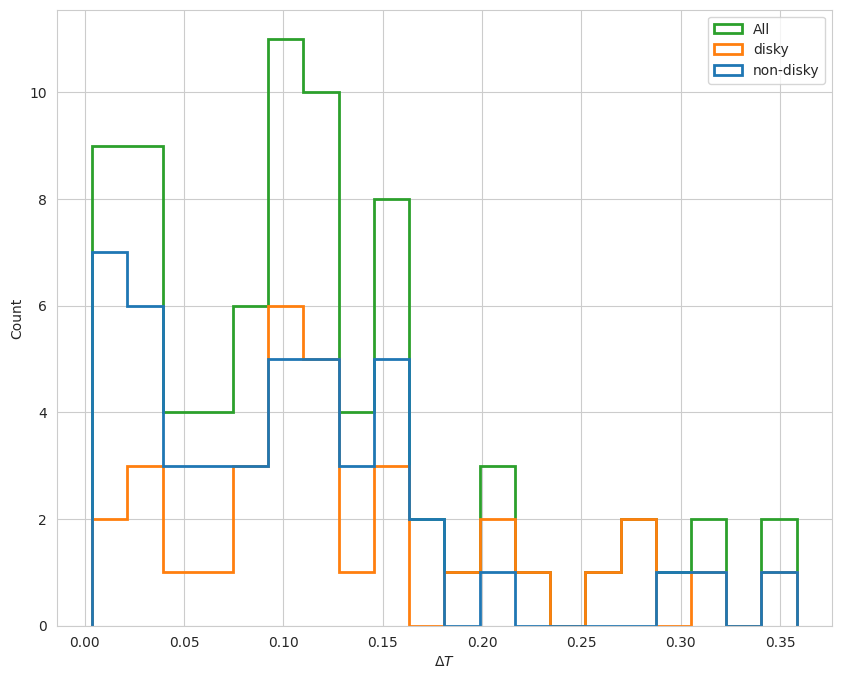

In [48]:

#create histograme of T_d - T_s for each mask
import numpy as np
plt.figure(figsize=(10, 8))
T_diff_hist = []
for mask in masks.keys():
    T_diff =  df.loc[masks[mask], 'T_d'] - df.loc[masks[mask], 'T_s']
    T_diff = np.abs(T_diff)
    T_diff_hist.append(T_diff)


plt.hist(T_diff_hist, bins=20, label=masks.keys(),histtype='step', linewidth=2)
plt.xlabel(r'$\Delta T$')
plt.ylabel('Count')
plt.legend()






In [9]:


#read dataframe from pickle file
df = pd.read_pickle('../../Data/BasicData/3DShapesDataframe.pickle')
dfNew = pd.read_pickle('../../Data/BasicData/3DShapesDataframeNew.pickle')
print(df.head())

        sims  hids       B_s       C_s       T_s       B_d       C_d  \
0  cptmarvel     1  0.821344  0.435779  0.401673  0.838949  0.491384   
1  cptmarvel     2  0.699131  0.286027  0.556765  0.696188  0.407700   
2  cptmarvel     3  0.803002  0.591766  0.546601  0.714478  0.512931   
3  cptmarvel     5  0.696995  0.597426  0.799583  0.794342  0.603670   
4  cptmarvel     6  0.893482  0.777884  0.510740  0.730509  0.565420   

        T_d  Stellar mass        mb  ...       rvir  \
0  0.390439  5.434489e+07  0.025451  ...  50.120488   
1  0.618054  1.492099e+07  0.065417  ...  43.415986   
2  0.664296  8.503522e+06  0.049119  ...  41.549595   
3  0.580602  1.222095e+07  0.017638  ...  39.311345   
4  0.685515  1.147486e+07  0.021597  ...  37.628723   

                                       diffs_at_reff  jz_jcirc_avgs     t_dyn  \
0  (9.785045995771247, 9.632508821536367, 2.45538...       0.072950  0.055614   
1  (24.972336904462402, 25.16052698355724, 2.6333...       0.077958  0.130

In [15]:
#create a new column for the ratio of total mass to stellar mass
df['M*/Mvir'] = np.log10(df['Stellar mass']/df['mvir'])


In [16]:
print(dfNew.head())


        sims  hids       B_s       C_s       T_s       B_d       C_d  \
0  cptmarvel     1  0.765644  0.351270  0.472034  0.868266  0.535226   
1  cptmarvel     2  0.607327  0.222890  0.664148  0.780389  0.408434   
2  cptmarvel     3  0.697201  0.472770  0.661839  0.819710  0.632769   
3  cptmarvel     5  0.899795  0.735958  0.415320  0.892738  0.749773   
4  cptmarvel     6  0.828873  0.684090  0.588265  0.860017  0.739055   

        T_d  Stellar mass        mb  ...          mvir       rvir  \
0  0.344924  5.434489e+07  0.025451  ...  1.517224e+10  50.120488   
1  0.469276  1.492099e+07  0.065417  ...  9.387201e+09  43.415986   
2  0.547156  8.503522e+06  0.049119  ...  8.162479e+09  41.549595   
3  0.463682  1.222095e+07  0.017638  ...  7.294522e+09  39.311345   
4  0.573759  1.147486e+07  0.021597  ...  6.183828e+09  37.628723   

   jz_jcirc_avgs     t_dyn  C_dm/C_star  B_dm/B_star  T_dm - T_star  \
0       0.072950  0.055614     1.523686     1.134033      -0.127109   
1       0.

In [2]:
dfNew

,sims,hids,B_s,C_s,T_s,B_d,C_d,T_d,Stellar mass,mb,...,mvir,rvir,jz_jcirc_avgs,t_dyn,C_dm/C_star,B_dm/B_star,T_dm - T_star,galaxy_class,feedback_type,htype
0,cptmarvel,1,0.765644,0.351270,0.472034,0.868266,0.535226,0.344924,5.434489e+07,0.025451,...,1.517224e+10,50.120488,0.072950,0.055614,1.523686,1.134033,-0.127109,disk,BWMDC,o
1,cptmarvel,2,0.607327,0.222890,0.664148,0.780389,0.408434,0.469276,1.492099e+07,0.065417,...,9.387201e+09,43.415986,0.077958,0.130042,1.832450,1.284957,-0.194872,elliptical,BWMDC,o
2,cptmarvel,3,0.697201,0.472770,0.661839,0.819710,0.632769,0.547156,8.503522e+06,0.049119,...,8.162479e+09,41.549595,0.023421,0.041705,1.338431,1.175714,-0.114683,elliptical,BWMDC,o
3,cptmarvel,5,0.899795,0.735958,0.415320,0.892738,0.749773,0.463682,1.222095e+07,0.017638,...,7.294522e+09,39.311345,0.032020,0.038145,1.018771,0.992157,0.048362,elliptical,BWMDC,o
4,cptmarvel,6,0.828873,0.684090,0.588265,0.860017,0.739055,0.573759,1.147486e+07,0.021597,...,6.183828e+09,37.628723,-0.000081,0.027308,1.080347,1.037574,-0.014507,elliptical,BWMDC,o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,storm,6,0.595438,0.439260,0.799768,0.581882,0.462997,0.841885,5.550684e+06,0.033209,...,8.187882e+09,40.860797,-0.000251,0.014573,1.054037,0.977232,0.042117,elliptical,BWMDC,o
19,storm,7,0.929809,0.567747,0.199886,0.908594,0.611285,0.278538,1.632306e+07,0.017504,...,7.766430e+09,40.226806,0.014235,0.030992,1.076685,0.977183,0.078653,elliptical,BWMDC,o
20,storm,8,0.541672,0.423811,0.861294,0.586054,0.475727,0.848591,1.735703e+07,0.020109,...,7.253821e+09,40.175464,0.002246,0.053839,1.122498,1.081936,-0.012703,elliptical,BWMDC,o
21,storm,14,0.889715,0.634125,0.348574,0.860215,0.625435,0.427097,1.471025e+06,0.011483,...,3.609216e+09,30.929002,0.000842,0.018570,0.986298,0.966844,0.078523,elliptical,BWMDC,o


Text(0, 0.5, 'Stellar mass')

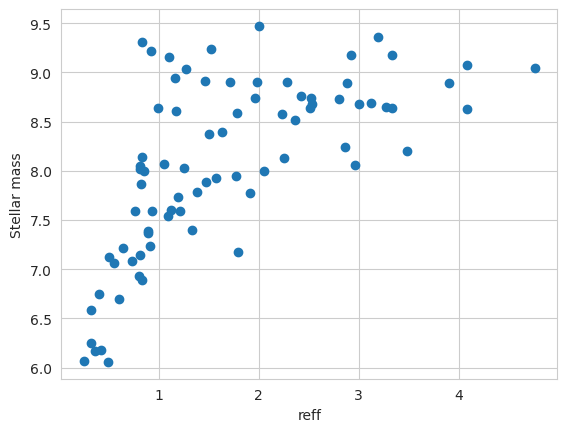

In [18]:
#plot 'Stellar mass' vs reff
import matplotlib.pyplot as plt
plt.scatter(df['reff'], np.log10(df['Stellar mass']))
plt.xlabel('reff')
plt.ylabel('Stellar mass')





22


(array([13.,  8.,  7.,  8.,  8.,  8.,  3.,  5.,  7.,  3.,  1.,  3.,  0.,
         1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([3.53602279e-05, 1.97708698e-02, 3.95063794e-02, 5.92418889e-02,
        7.89773985e-02, 9.87129080e-02, 1.18448418e-01, 1.38183927e-01,
        1.57919437e-01, 1.77654946e-01, 1.97390456e-01, 2.17125965e-01,
        2.36861475e-01, 2.56596985e-01, 2.76332494e-01, 2.96068004e-01,
        3.15803513e-01, 3.35539023e-01, 3.55274532e-01, 3.75010042e-01,
        3.94745552e-01]),
 <BarContainer object of 20 artists>)

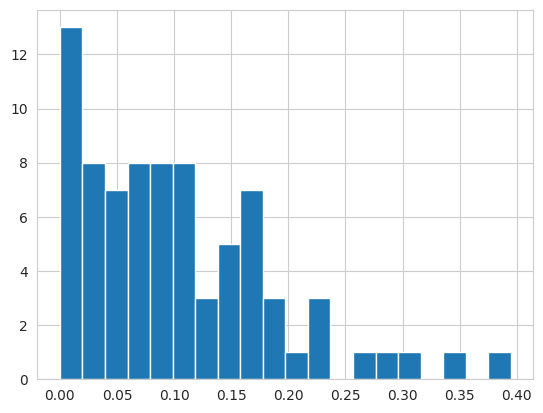

In [53]:
#print number of galaxies with abs 'T_dm - T_star' > 0.1
print(len(dfNew[abs(dfNew['T_dm - T_star']) > 1/6]))

from matplotlib import pyplot as plt
#make histogram of abs 'T_dm - T_star'
dfNew['abs_T_dm - T_star'] = abs(df['T_dm - T_star'])
plt.hist(dfNew['abs_T_dm - T_star'], bins=20)


Number of stellar component points in the shaded region: 33
Number of dark matter component points in the shaded region: 39
Total number of points in the shaded region: 72


Text(0, 0.5, 'C_s')

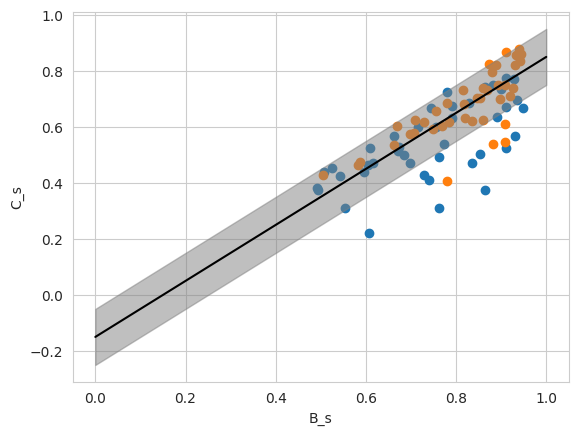

In [38]:
#how many non-disky galaxies have c = (b - 0.1) pm 0.1
#plot c_s vs b_s for non disky and shade line where c_s = b_s - 0.1
plt.scatter(dfNew['B_s'][dfNew['galaxy_class'] != 'disk'], dfNew['C_s'][dfNew['galaxy_class'] != 'disk'])
#plot dark matter
plt.scatter(dfNew['B_d'][dfNew['galaxy_class'] != 'disk'], dfNew['C_d'][dfNew['galaxy_class'] != 'disk'])

x = np.linspace(0, 1, 100)
y = x - 0.15
plt.plot(x, y, c='black')
#fill area 0.1 above and below line
plt.fill_between(x, y - 0.1, y + 0.1, color='gray', alpha=0.5)

#how many are in shaded area
# For stellar components
stellar_count = ((dfNew['B_s'] - 0.3 <= dfNew['C_s']) & 
                 (dfNew['C_s'] <= dfNew['B_s']) & 
                 (dfNew['galaxy_class'] != 'disk')).sum()

# For dark matter components
dark_matter_count = ((dfNew['B_d'] - 0.3 <= dfNew['C_d']) & 
                     (dfNew['C_d'] <= dfNew['B_d']) & 
                     (dfNew['galaxy_class'] != 'disk')).sum()

# Total count
total_count = stellar_count + dark_matter_count

print(f"Number of stellar component points in the shaded region: {stellar_count}")
print(f"Number of dark matter component points in the shaded region: {dark_matter_count}")
print(f"Total number of points in the shaded region: {total_count}")



plt.xlabel('B_s')
plt.ylabel('C_s')




In [48]:
#print average values for disky and non-disky galaxies
# Calculate average values for disk and non-disk galaxies for each shape parameter b, c, t
#clump an irregular galaxies with elliptical galaxies
dfNew['galaxy_class'] = dfNew['galaxy_class'].replace('irregular', 'elliptical')
avg_values = dfNew.groupby('galaxy_class')[['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d']].mean()
print(avg_values)


                   B_s       C_s       T_s       B_d       C_d       T_d
galaxy_class                                                            
disk          0.770708  0.304469  0.432693  0.884181  0.590129  0.326668
elliptical    0.744534  0.541313  0.603443  0.820782  0.675911  0.577567


In [25]:
import pandas as pd
import numpy as np

# Read the CSV data
df = dfNew

# Define helper functions
def get_range(series):
    return f"{series.min():.2f},{series.max():.2f}"

def get_ranges(df, columns):
    return {col: get_range(df[col]) for col in columns}

def format_latex_var(name, value):
    return f"\\newcommand{{\\{name}}}{{{value}}}"


# Define column sets
columns = ['B_s', 'C_s', 'B_d', 'C_d', 'T_s', 'T_d', 'C_dm/C_star', 'B_dm/B_star', 'abs_T_dm - T_star']

# Get ranges for all galaxies
all_ranges = get_ranges(df, columns)

# Get ranges for disk galaxies
disk_ranges = get_ranges(df[df['galaxy_class'] == 'disk'], columns)

# Get ranges for non-disk galaxies
non_disk_ranges = get_ranges(df[df['galaxy_class'].isin(['elliptical', 'irregular'])], columns)

# Count galaxies
total_galaxies = len(df)
disk_galaxies = df[df['galaxy_class'] == 'disk'].shape[0]
non_disk_galaxies = df[df['galaxy_class'].isin(['elliptical', 'irregular'])].shape[0]

# Count disk galaxies in oblate region
disk_oblate = df[(df['galaxy_class'] == 'disk') & (df['T_s'] < 1/3)].shape[0]

# Count non-disk galaxies in prolate region
non_disk_prolate = df[(df['galaxy_class'].isin(['elliptical', 'irregular'])) & (df['T_s'] > 2/3)].shape[0]

# Format results as LaTeX variable definitions
latex_output = "% LaTeX variable definitions for galaxy shape parameters\n\n"

for col in columns:
    #remove disallowed characters from column names for latex
    col_latex = col.replace('/', '')
    col_latex = col_latex.replace(' ', '')
    col_latex = col_latex.replace('_', '')
    col_latex = col_latex.replace('-', '')
    latex_output += f"% {col} ranges\n"
    latex_output += format_latex_var(f"{col_latex}RangeAll", all_ranges[col]) + "\n"
    latex_output += format_latex_var(f"{col_latex}RangeDisk", disk_ranges[col]) + "\n"
    latex_output += format_latex_var(f"{col_latex}RangeNonDisk", non_disk_ranges[col]) + "\n\n"

latex_output += "% Galaxy counts and fractions\n"
latex_output += format_latex_var("totalGalaxies", str(total_galaxies)) + "\n"
latex_output += format_latex_var("diskGalaxies", f"{disk_galaxies}/{total_galaxies}") + "\n"
latex_output += format_latex_var("nonDiskGalaxies", f"{non_disk_galaxies}/{total_galaxies}") + "\n"
latex_output += format_latex_var("diskOblateFraction", f"{disk_oblate}/{total_galaxies}") + "\n"
latex_output += format_latex_var("nonDiskProlateFraction", f"{non_disk_prolate}/{total_galaxies}") + "\n"

print(latex_output)

% LaTeX variable definitions for galaxy shape parameters

% B_s ranges
\newcommand{\BsRangeAll}{0.42,0.96}
\newcommand{\BsRangeDisk}{0.42,0.96}
\newcommand{\BsRangeNonDisk}{0.49,0.95}

% C_s ranges
\newcommand{\CsRangeAll}{0.20,0.78}
\newcommand{\CsRangeDisk}{0.20,0.59}
\newcommand{\CsRangeNonDisk}{0.22,0.78}

% B_d ranges
\newcommand{\BdRangeAll}{0.51,0.98}
\newcommand{\BdRangeDisk}{0.64,0.98}
\newcommand{\BdRangeNonDisk}{0.51,0.95}

% C_d ranges
\newcommand{\CdRangeAll}{0.41,0.88}
\newcommand{\CdRangeDisk}{0.43,0.85}
\newcommand{\CdRangeNonDisk}{0.41,0.88}

% T_s ranges
\newcommand{\TsRangeAll}{0.08,0.92}
\newcommand{\TsRangeDisk}{0.08,0.89}
\newcommand{\TsRangeNonDisk}{0.18,0.92}

% T_d ranges
\newcommand{\TdRangeAll}{0.09,0.91}
\newcommand{\TdRangeDisk}{0.09,0.82}
\newcommand{\TdRangeNonDisk}{0.25,0.91}

% C_dm/C_star ranges
\newcommand{\CdmCstarRangeAll}{0.88,4.04}
\newcommand{\CdmCstarRangeDisk}{1.27,4.04}
\newcommand{\CdmCstarRangeNonDisk}{0.88,1.90}

% B_dm/B_star ranges
\newco

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframes
df = pd.read_pickle('../../Data/BasicData/3DShapesDataframe.pickle')
dfNew = pd.read_pickle('../../Data/BasicData/3DShapesDataframeNew.pickle')

# Find common shapes

#filter out sims that start with r




common_shapes = list(set(df['sims']).intersection(set(dfNew['sims'])))
#common_shapes = common_shapes[:10]  # Limiting to 10 as in your original code

df_common = df[df['sims'].isin(common_shapes)]
dfNew_common = dfNew[dfNew['sims'].isin(common_shapes)]


In [23]:
df_common

,sims,hids,B_s,C_s,T_s,B_d,C_d,T_d,Stellar mass,mb,...,rvir,diffs_at_reff,jz_jcirc_avgs,t_dyn,C_dm/C_star,B_dm/B_star,T_dm - T_star,galaxy_class,feedback_type,htype
0,cptmarvel,1,0.821344,0.435779,0.401673,0.838949,0.491384,0.390439,5.434489e+07,0.025451,...,50.120488,"(9.785045995771247, 9.632508821536367, 2.45538...",0.072950,0.055614,1.127599,1.021435,-0.011234,elliptical,BWMDC,o
1,cptmarvel,2,0.699131,0.286027,0.556765,0.696188,0.407700,0.618054,1.492099e+07,0.065417,...,43.415986,"(24.972336904462402, 25.16052698355724, 2.6333...",0.077958,0.130042,1.425390,0.995790,0.061289,elliptical,BWMDC,o
2,cptmarvel,3,0.803002,0.591766,0.546601,0.714478,0.512931,0.664296,8.503522e+06,0.049119,...,41.549595,"(14.251780833027727, 15.692349881961007, 6.542...",0.023421,0.041705,0.866780,0.889759,0.117695,elliptical,BWMDC,o
3,cptmarvel,5,0.696995,0.597426,0.799583,0.794342,0.603670,0.580602,1.222095e+07,0.017638,...,39.311345,"(43.649512415302794, 51.932563388410685, 35.29...",0.032020,0.038145,1.010451,1.139667,-0.218981,elliptical,BWMDC,o
4,cptmarvel,6,0.893482,0.777884,0.510740,0.730509,0.565420,0.685515,1.147486e+07,0.021597,...,37.628723,"(24.11626257900081, 25.72772570740389, 13.7098...",-0.000081,0.027308,0.726869,0.817598,0.174774,elliptical,BWMDC,o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,storm,6,0.701056,0.552676,0.732159,0.545103,0.367813,0.812826,5.550684e+06,0.033209,...,40.860797,"(11.832137009789403, 17.003283341804813, 17.03...",-0.000251,0.014573,0.665513,0.777546,0.080667,elliptical,BWMDC,o
19,storm,7,0.934470,0.641121,0.215236,0.847821,0.545017,0.400025,1.632306e+07,0.017504,...,40.226806,"(48.85870764579901, 48.867194008131804, 2.7311...",0.014235,0.030992,0.850100,0.907275,0.184789,elliptical,BWMDC,o
20,storm,8,0.570612,0.459222,0.854630,0.545284,0.461363,0.892676,1.735703e+07,0.020109,...,40.175464,"(9.362053323612017, 11.976990199821488, 9.1009...",0.002246,0.053839,1.004662,0.955613,0.038046,elliptical,BWMDC,o
21,storm,14,0.842658,0.636013,0.486873,0.705727,0.485762,0.656971,1.471025e+06,0.011483,...,30.929002,"(60.00894483813079, 60.42006699824293, 18.7951...",0.000842,0.018570,0.763760,0.837501,0.170098,elliptical,BWMDC,o


In [24]:
# add '../' to the path
import sys
sys.path.append('../')
from PlotClasses import GeneralPlotter

/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


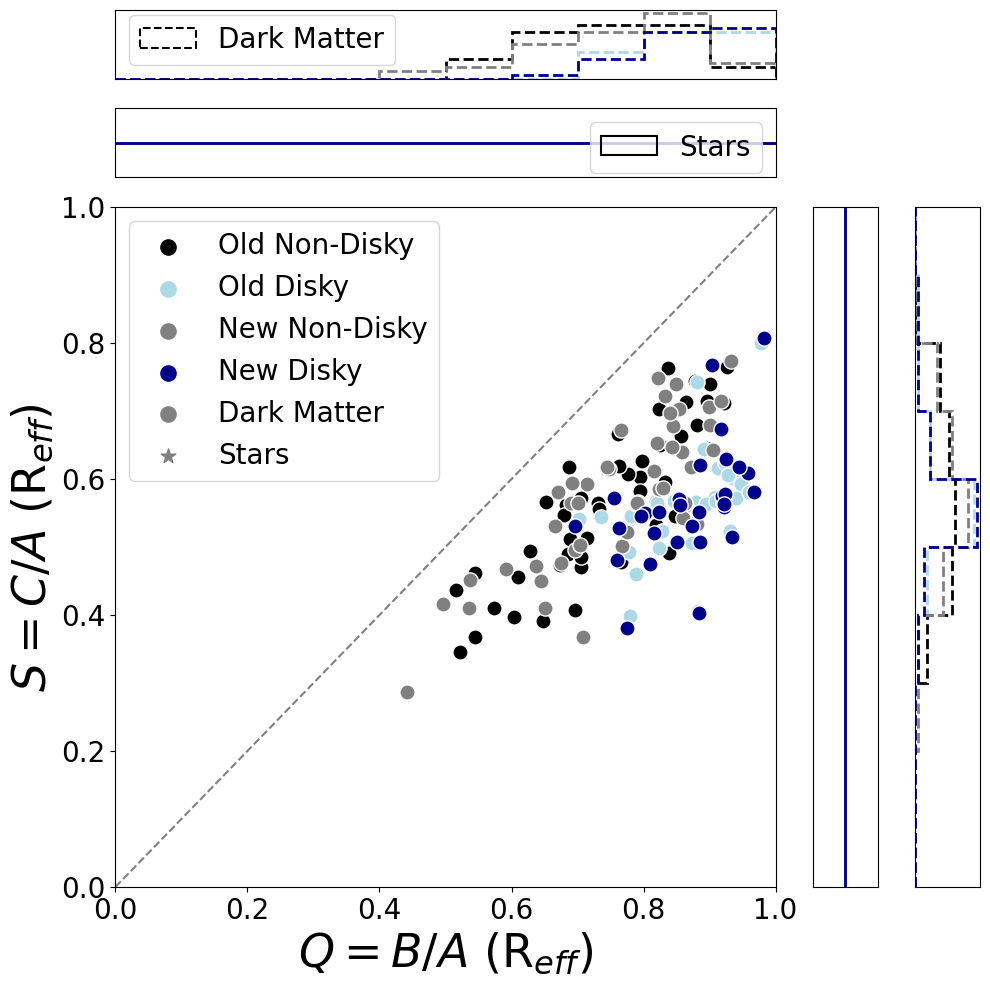

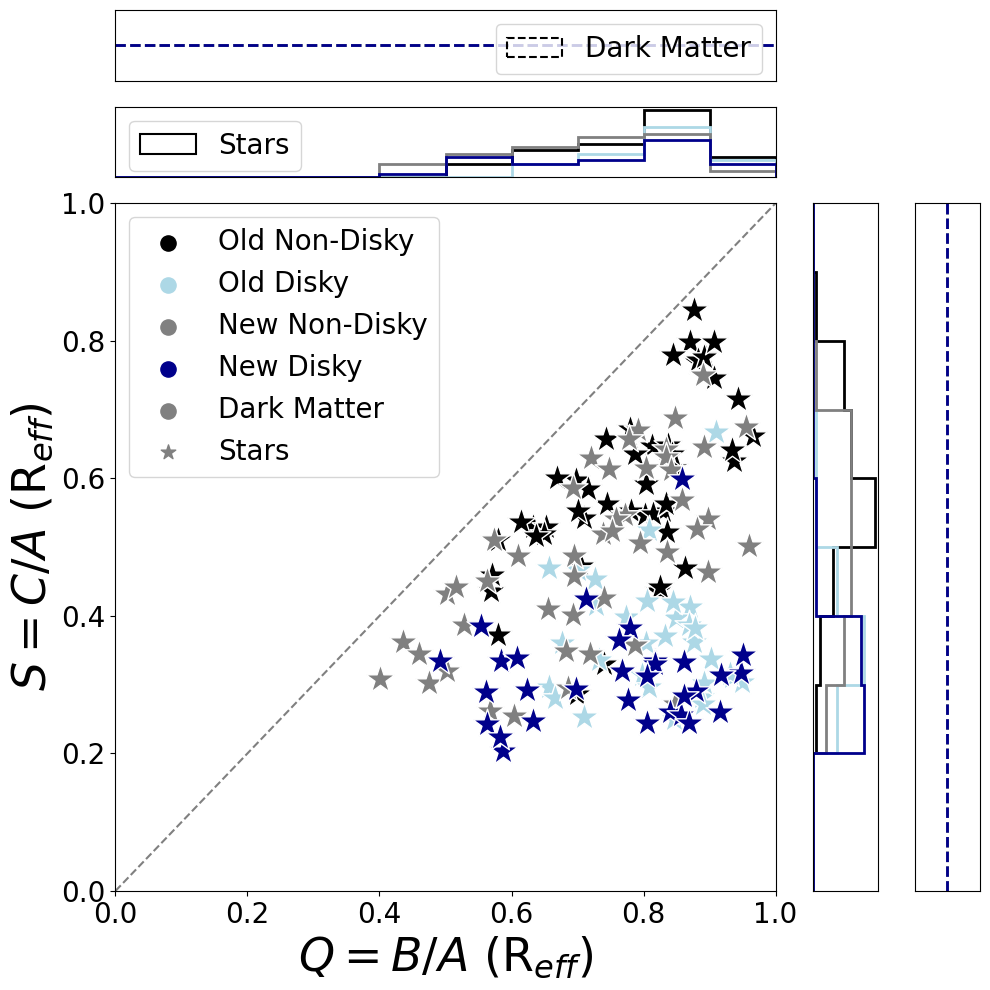

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

# Assuming GeneralPlotter is defined as in your provided code

# Function to categorize galaxies as disky or non-disky
def categorize_galaxy(galaxy_class):
    return 'disky' if galaxy_class == 'disk' else 'non-disky'

# Prepare the data
data = {
    'B_d': np.concatenate([df_common['B_d'].values, dfNew_common['B_d'].values]),
    'C_d': np.concatenate([df_common['C_d'].values, dfNew_common['C_d'].values]),
    'B_s': np.concatenate([df_common['B_s'].values, dfNew_common['B_s'].values]),
    'C_s': np.concatenate([df_common['C_s'].values, dfNew_common['C_s'].values]),
    'galaxy_type': np.concatenate([
        df_common['galaxy_class'].apply(categorize_galaxy).values,
        dfNew_common['galaxy_class'].apply(categorize_galaxy).values
    ]),
    'is_old': np.concatenate([np.ones(len(df_common), dtype=bool), np.zeros(len(dfNew_common), dtype=bool)]),
    'reff_multi': 1  # Assuming Reff is 1, adjust if needed
}

# Prepare masks
masks = {
    'Old Non-Disky': (data['is_old'] & (data['galaxy_type'] == 'non-disky')),
    'Old Disky': (data['is_old'] & (data['galaxy_type'] == 'disky')),
    'New Non-Disky': (~data['is_old'] & (data['galaxy_type'] == 'non-disky')),
    'New Disky': (~data['is_old'] & (data['galaxy_type'] == 'disky'))
}

# Prepare labels and colors
labels = {
    'Old Non-Disky': 'Old Non-Disky',
    'Old Disky': 'Old Disky',
    'New Non-Disky': 'New Non-Disky',
    'New Disky': 'New Disky',
    'B': 'Q', 'C': 'S',
}

colors = {
    'Old Non-Disky': 'black',
    'Old Disky': 'lightblue',
    'New Non-Disky': 'gray',
    'New Disky': 'darkblue'
}

# Create datasets with only dark matter or stars by setting all of the values for that dataset to np.nan
g = np.copy(data['B_d']) * np.nan

# Dark Matter
data_dm = data.copy()
data_dm['B_s'] = g
data_dm['C_s'] = g

# Stars
data_stars = data.copy()
data_stars['B_d'] = g
data_stars['C_d'] = g

# Create GeneralPlotter instance for Dark Matter
plotter_dm = GeneralPlotter(data_dm, masks, labels, colors)
# Plot Dark Matter (B_d vs C_d)
plotter_dm.plot_data_with_masks('B', 'C', show_scatter=True, show_lines=False, filename='dark_matter_plot.png')

# Create GeneralPlotter instance for Stars
plotter_stars = GeneralPlotter(data_stars, masks, labels, colors)
# Plot Stars (B_s vs C_s)
plotter_stars.plot_data_with_masks('B', 'C', show_scatter=True, show_lines=False, filename='stars_plot.png')

# Show the plots
plt.show()

/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN axis encountered
  xmin = min(xmin, np.nanmin(xi))
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN axis encountered
  xmax = max(xmax, np.nanmax(xi))


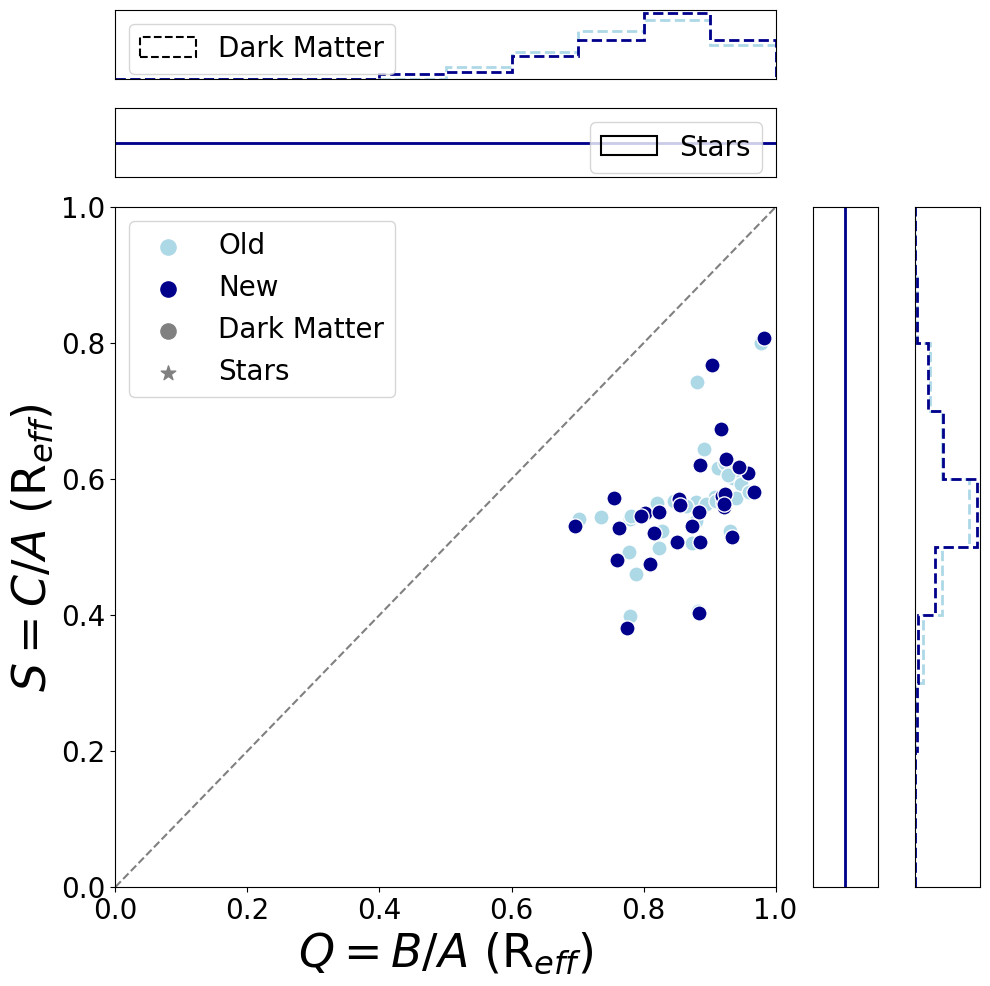

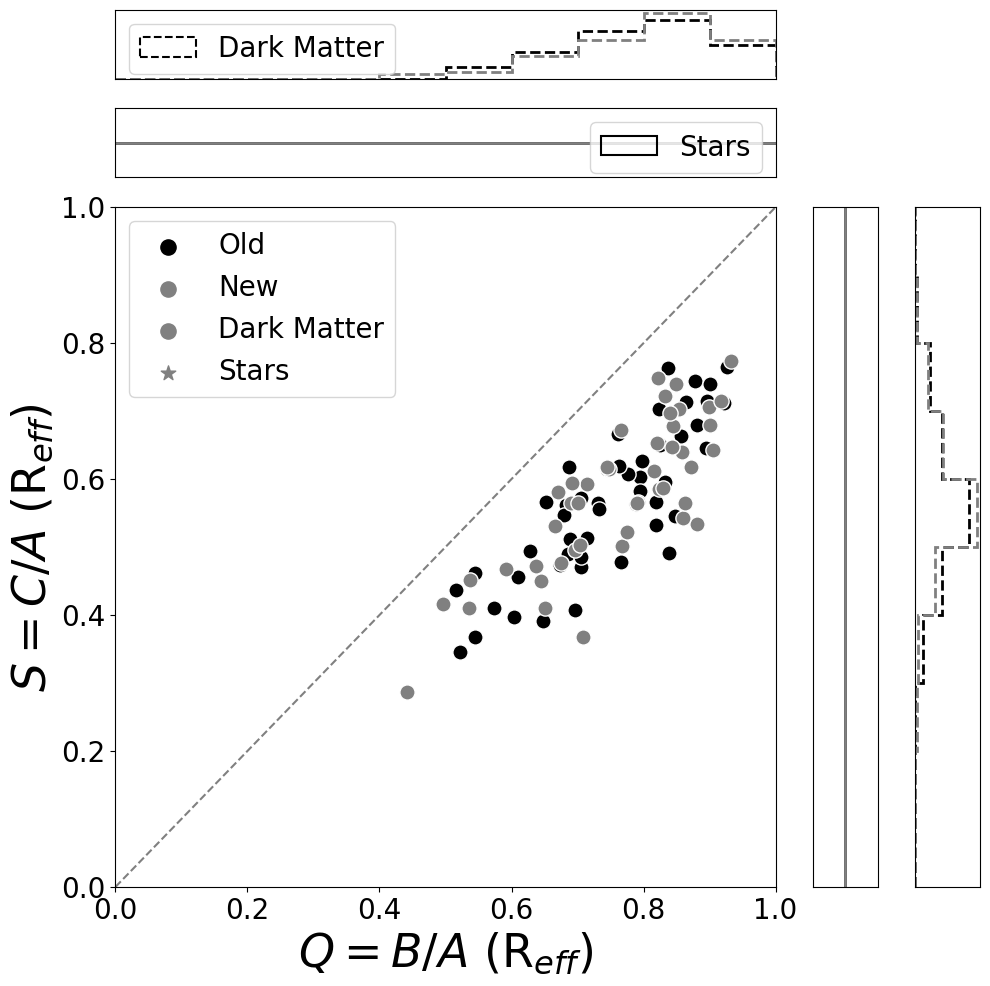

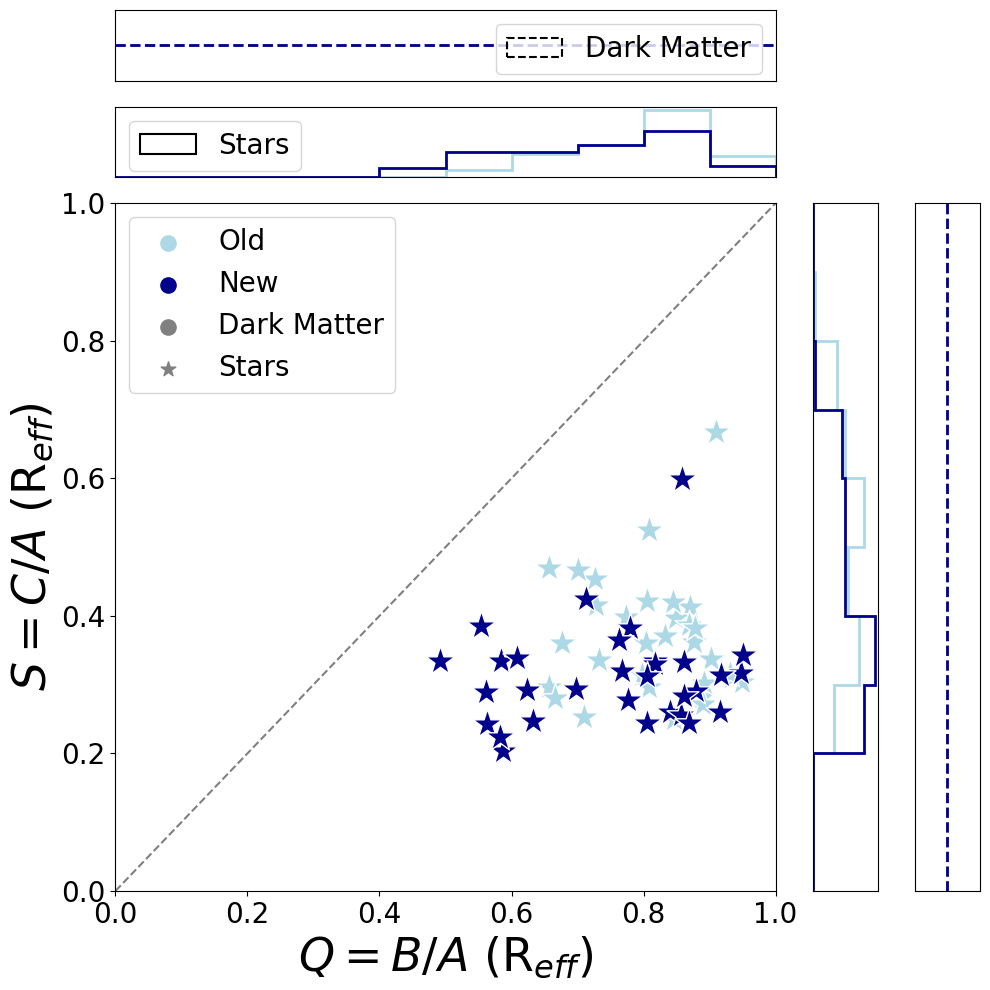

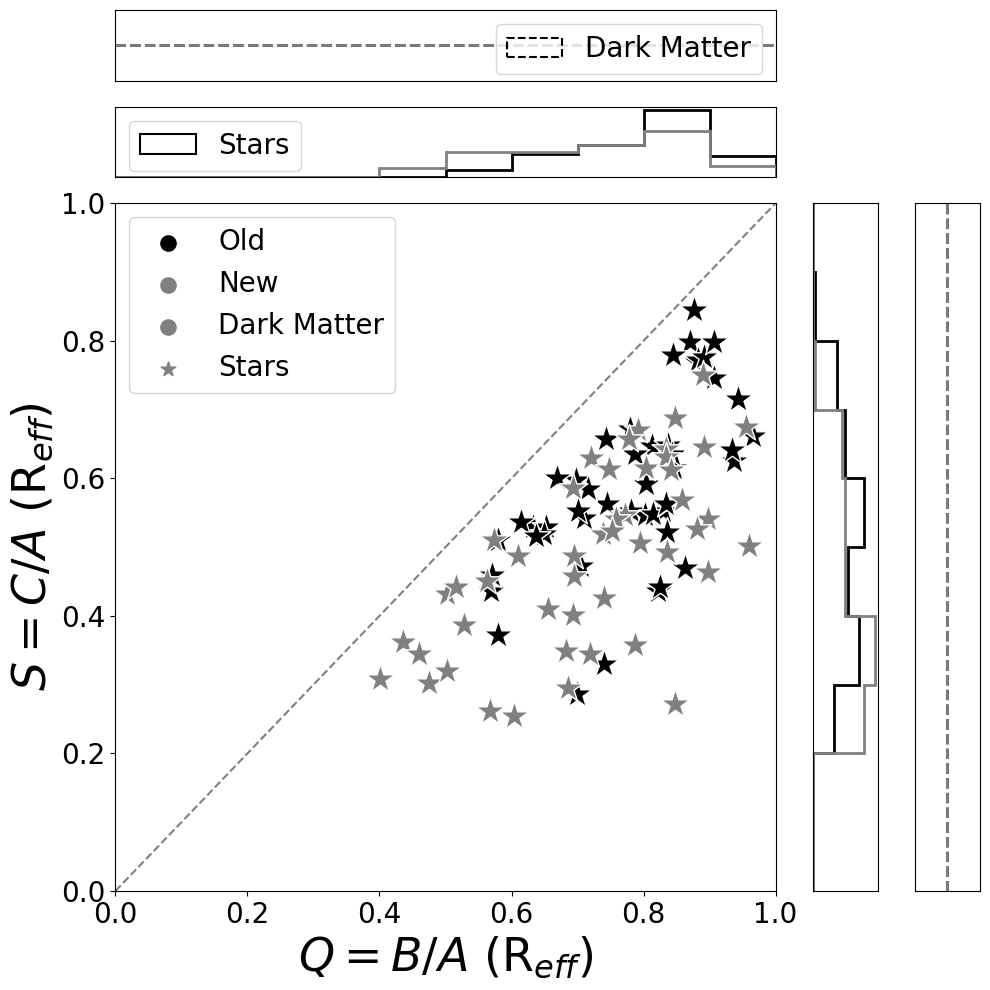

All plots have been saved.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

# Assuming GeneralPlotter is defined as in your provided code

# Function to categorize galaxies as disky or non-disky
def categorize_galaxy(galaxy_class):
    return 'disky' if galaxy_class == 'disk' else 'non-disky'

# Prepare the data
data = {
    'B_d': np.concatenate([df_common['B_d'].values, dfNew_common['B_d'].values]),
    'C_d': np.concatenate([df_common['C_d'].values, dfNew_common['C_d'].values]),
    'B_s': np.concatenate([df_common['B_s'].values, dfNew_common['B_s'].values]),
    'C_s': np.concatenate([df_common['C_s'].values, dfNew_common['C_s'].values]),
    'galaxy_type': np.concatenate([
        df_common['galaxy_class'].apply(categorize_galaxy).values,
        dfNew_common['galaxy_class'].apply(categorize_galaxy).values
    ]),
    'is_old': np.concatenate([np.ones(len(df_common), dtype=bool), np.zeros(len(dfNew_common), dtype=bool)]),
    'reff_multi': 1  # Assuming Reff is 1, adjust if needed
}

# Prepare masks
masks = {
    'Old Non-Disky': (data['is_old'] & (data['galaxy_type'] == 'non-disky')),
    'Old Disky': (data['is_old'] & (data['galaxy_type'] == 'disky')),
    'New Non-Disky': (~data['is_old'] & (data['galaxy_type'] == 'non-disky')),
    'New Disky': (~data['is_old'] & (data['galaxy_type'] == 'disky'))
}

# Prepare labels and colors
labels = {
    'Old Non-Disky': 'Old Non-Disky',
    'Old Disky': 'Old Disky',
    'New Non-Disky': 'New Non-Disky',
    'New Disky': 'New Disky',
    'B': 'Q', 'C': 'S',
}

colors = {
    'Old Non-Disky': 'black',
    'Old Disky': 'lightblue',
    'New Non-Disky': 'gray',
    'New Disky': 'darkblue'
}

# Create datasets with only dark matter or stars by setting all of the values for that dataset to np.nan
g = np.copy(data['B_d']) * np.nan

# Dark Matter
data_dm = data.copy()
data_dm['B_s'] = g
data_dm['C_s'] = g

# Stars
data_stars = data.copy()
data_stars['B_d'] = g
data_stars['C_d'] = g

# Function to create and save a plot
def create_plot(data, masks, labels, colors, title, filename, galaxy_type):
    plotter = GeneralPlotter(data, masks, labels, colors)
    plotter.plot_data_with_masks('B', 'C', show_scatter=True, show_lines=False)

# Create 4 plots
#DM disky
#apply disky mask to data in data_dm


def mask_data(mask, data):
    for key in ['B_d', 'C_d', 'B_s', 'C_s']:
        data[key] = np.ma.masked_array(data[key], ~mask)
    return data

def old_new_masks(data):
    masks = {'Old': data['is_old'], 'New': ~data['is_old']}
    labels = {'Old': 'Old', 'New': 'New', 'B': 'Q', 'C': 'S'}
    return masks,labels
data_dm_disky = data_dm.copy()
#mask data_dm_disky for B_d and C_d and B_s and C_s
disky_mask = masks['Old Disky'] | masks['New Disky']
data_dm_disky = mask_data(disky_mask, data_dm_disky)
masks, labels = old_new_masks(data_dm_disky)
colors = {'Old': 'lightblue', 'New': 'darkblue'}
create_plot(data_dm_disky, masks, labels, colors, 'DM Disky', 'dm_disky_plot.png', 'disky')


#DM non-disky
data_dm_non_disky = data_dm.copy()
#mask data_dm_non_disky for B_d and C_d and B_s and C_s
non_disky_mask = ~disky_mask
data_dm_non_disky = mask_data(non_disky_mask, data_dm_non_disky)
masks, labels = old_new_masks(data_dm_non_disky)
colors = {'Old': 'black', 'New': 'gray'}
create_plot(data_dm_non_disky, masks, labels, colors, 'DM Non-Disky', 'dm_non_disky_plot.png', 'non-disky')


#Stars disky
data_stars_disky = data_stars.copy()
#mask data_stars_disky for B_d and C_d and B_s and C_s

data_stars_disky = mask_data(disky_mask, data_stars_disky)
masks, labels = old_new_masks(data_stars_disky)
colors = {'Old': 'lightblue', 'New': 'darkblue'}
create_plot(data_stars_disky, masks, labels, colors, 'Stars Disky', 'stars_disky_plot.png', 'disky')


#Stars non-disky
data_stars_non_disky = data_stars.copy()
#mask data_stars_non_disky for B_d and C_d and B_s and C_s
data_stars_non_disky = mask_data(non_disky_mask, data_stars_non_disky)
masks, labels = old_new_masks(data_stars_non_disky)
colors = {'Old': 'black', 'New': 'gray'}
create_plot(data_stars_non_disky, masks, labels, colors, 'Stars Non-Disky', 'stars_non_disky_plot.png', 'non-disky')


print("All plots have been saved.")

In [19]:
# find point where C_s > B_s
dfNew[dfNew['C_s'] > dfNew['B_s']][['C_s', 'B_s', 'sims','hids']]

,C_s,B_s,sims,hids
25,0.386946,0.34457,rogue,7


/tmp/ipykernel_1660702/265158796.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_1660702/265158796.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


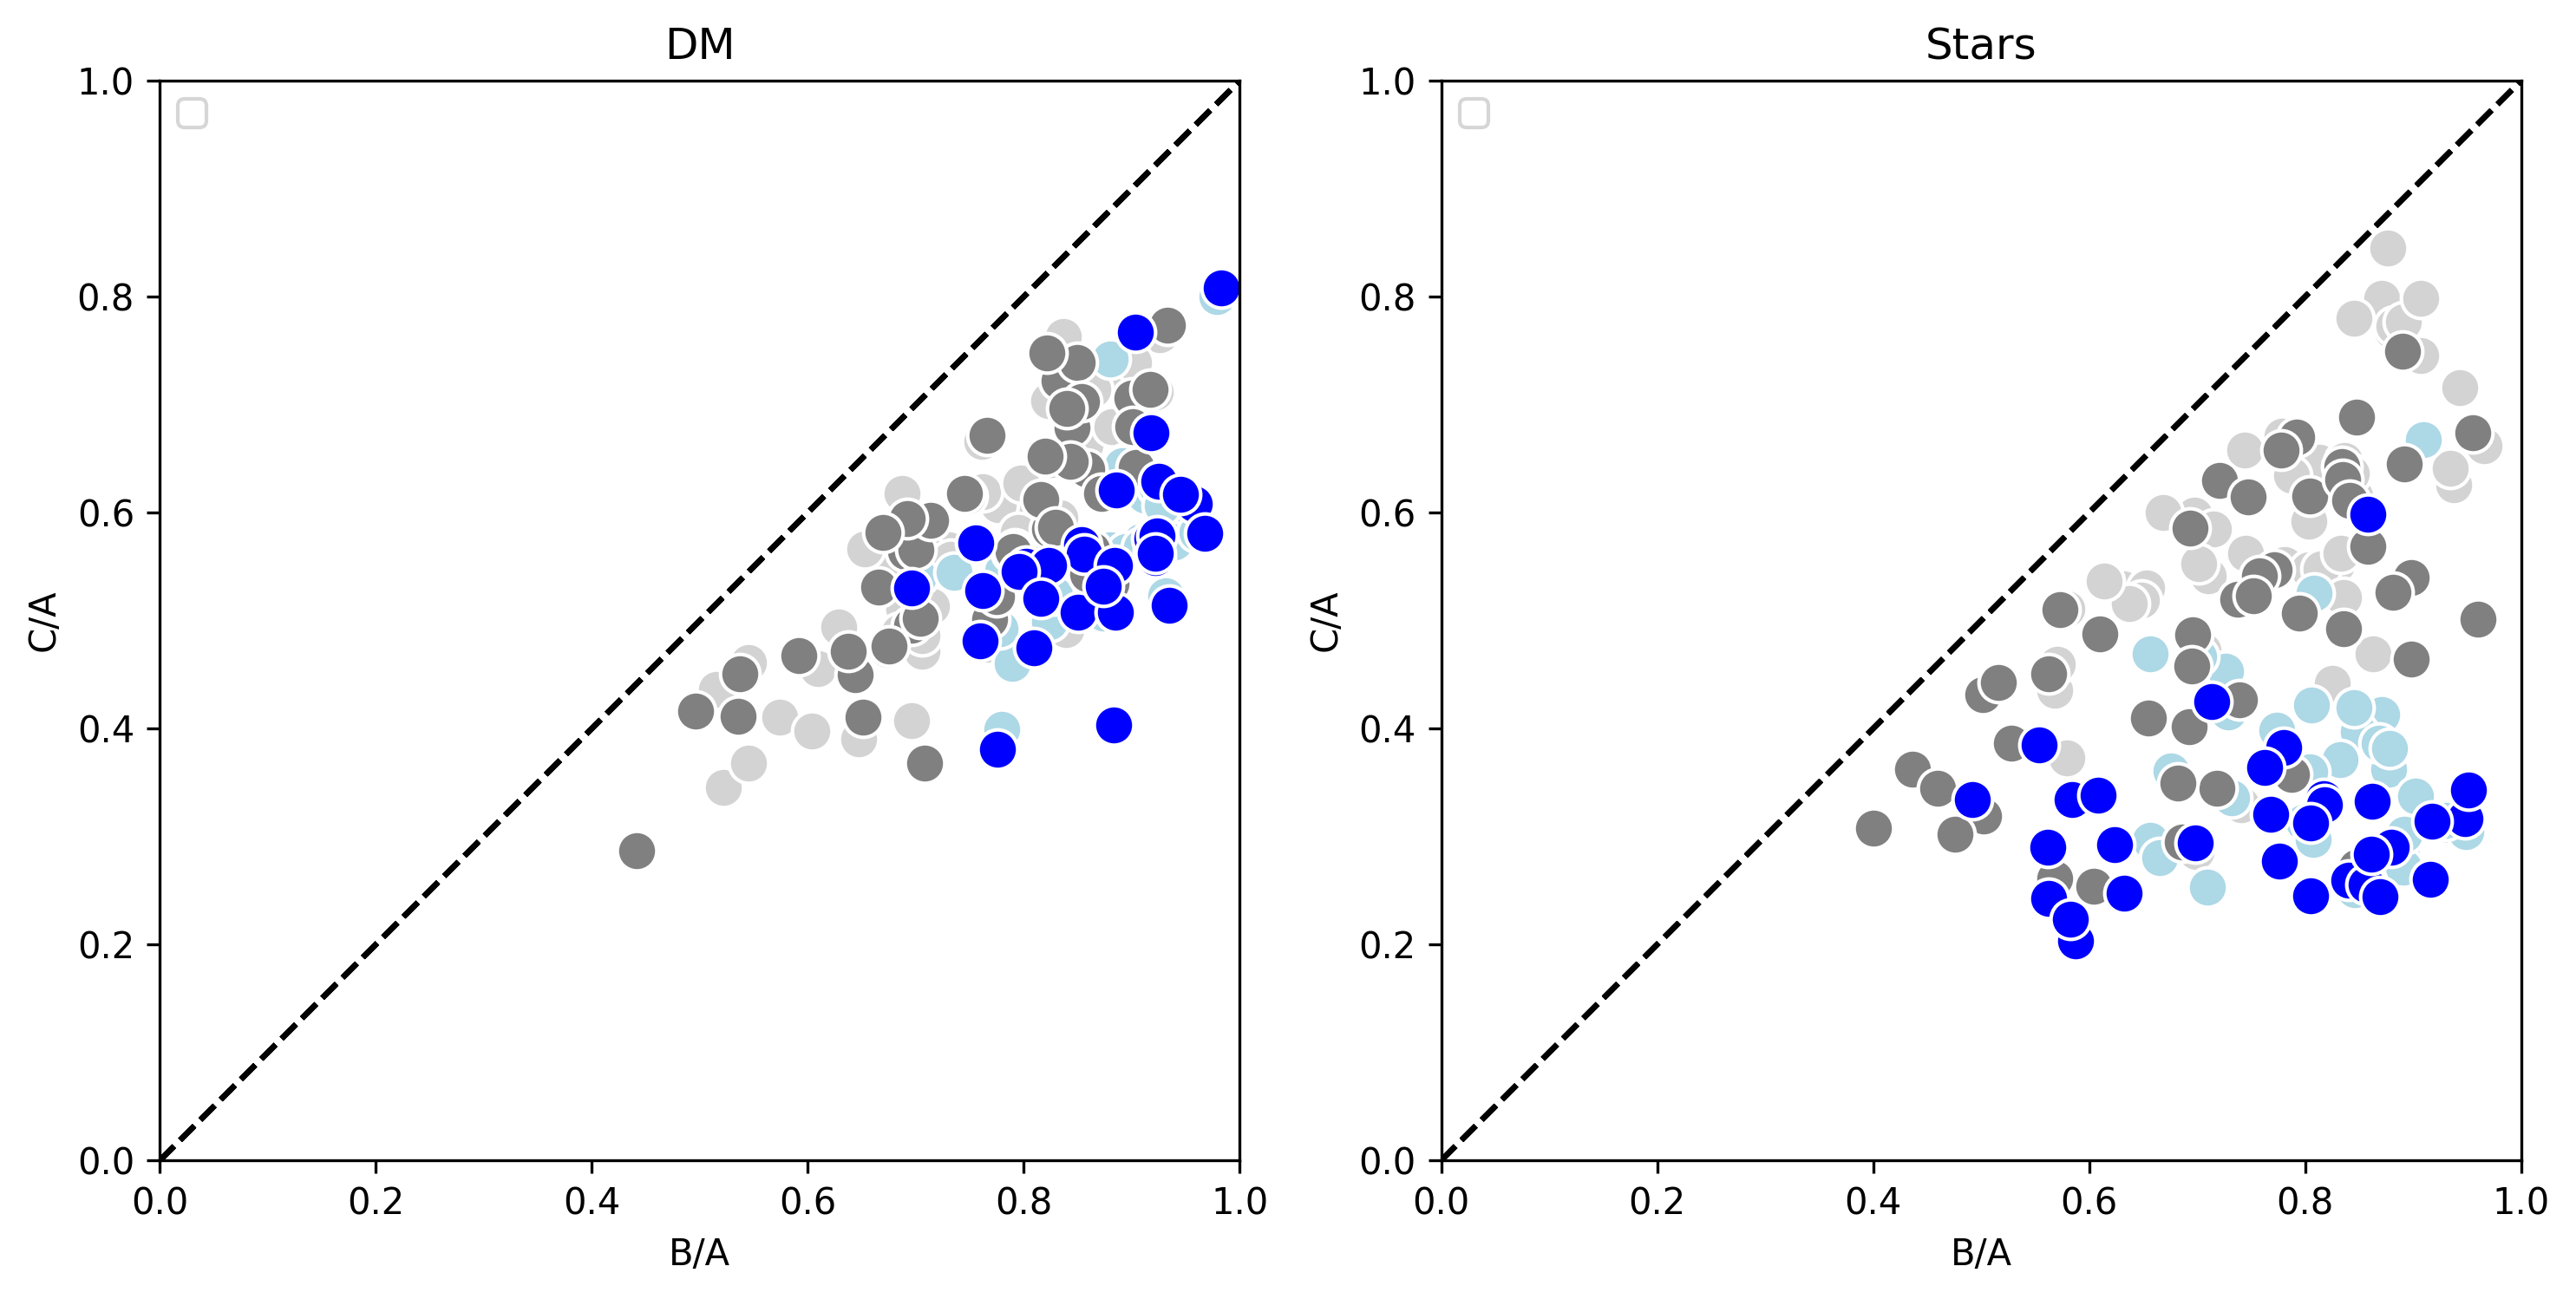

In [29]:

# Create the first plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5),dpi = 300)

point_size = 120

# Define color map for galaxy types
color_map = {'elliptical': 'gray', 'irregular': 'gray', 'disk': 'blue'}

# Function to plot data for each dataset
def plot_data(ax, data, label, marker, x_column, y_column):
    for galaxy_class in color_map.keys():
        mask = data['galaxy_class'] == galaxy_class
        color = color_map[galaxy_class]
        #lighter color for dfNew
        if label == 'df':
            color = 'light' + color

        ax.grid(False)
        #plot dashed line at x = y
        ax.plot([0,1], [0,1], c='black', linestyle='--')

        ax.scatter(data.loc[mask, x_column], data.loc[mask, y_column],
                   color=color,
                   #label=f'{label} - {galaxy_class}',
                   alpha=1,
                   marker=marker,
                    s=point_size,
                   edgecolors='white')


# Plot B_d vs C_d
plot_data(axs[0], df_common, 'df', 'o', 'B_d', 'C_d')
plot_data(axs[0], dfNew_common, 'dfNew', 'o', 'B_d', 'C_d')
axs[0].set_xlabel('B/A')
axs[0].set_ylabel('C/A')
axs[0].legend()
axs[0].set_title('DM')

# Plot B_s vs C_s
plot_data(axs[1], df_common, 'df', 'o', 'B_s', 'C_s')  # Circle for df
plot_data(axs[1], dfNew_common, 'dfNew', 'o', 'B_s', 'C_s')  # Triangle for dfNew
axs[1].set_xlabel('B/A')
axs[1].set_ylabel('C/A')
axs[1].legend()
axs[1].set_title('Stars')

# Set axis limits from 0 to 1 and make equal aspect ratio
for ax in axs:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')


plt.tight_layout()
plt.show()

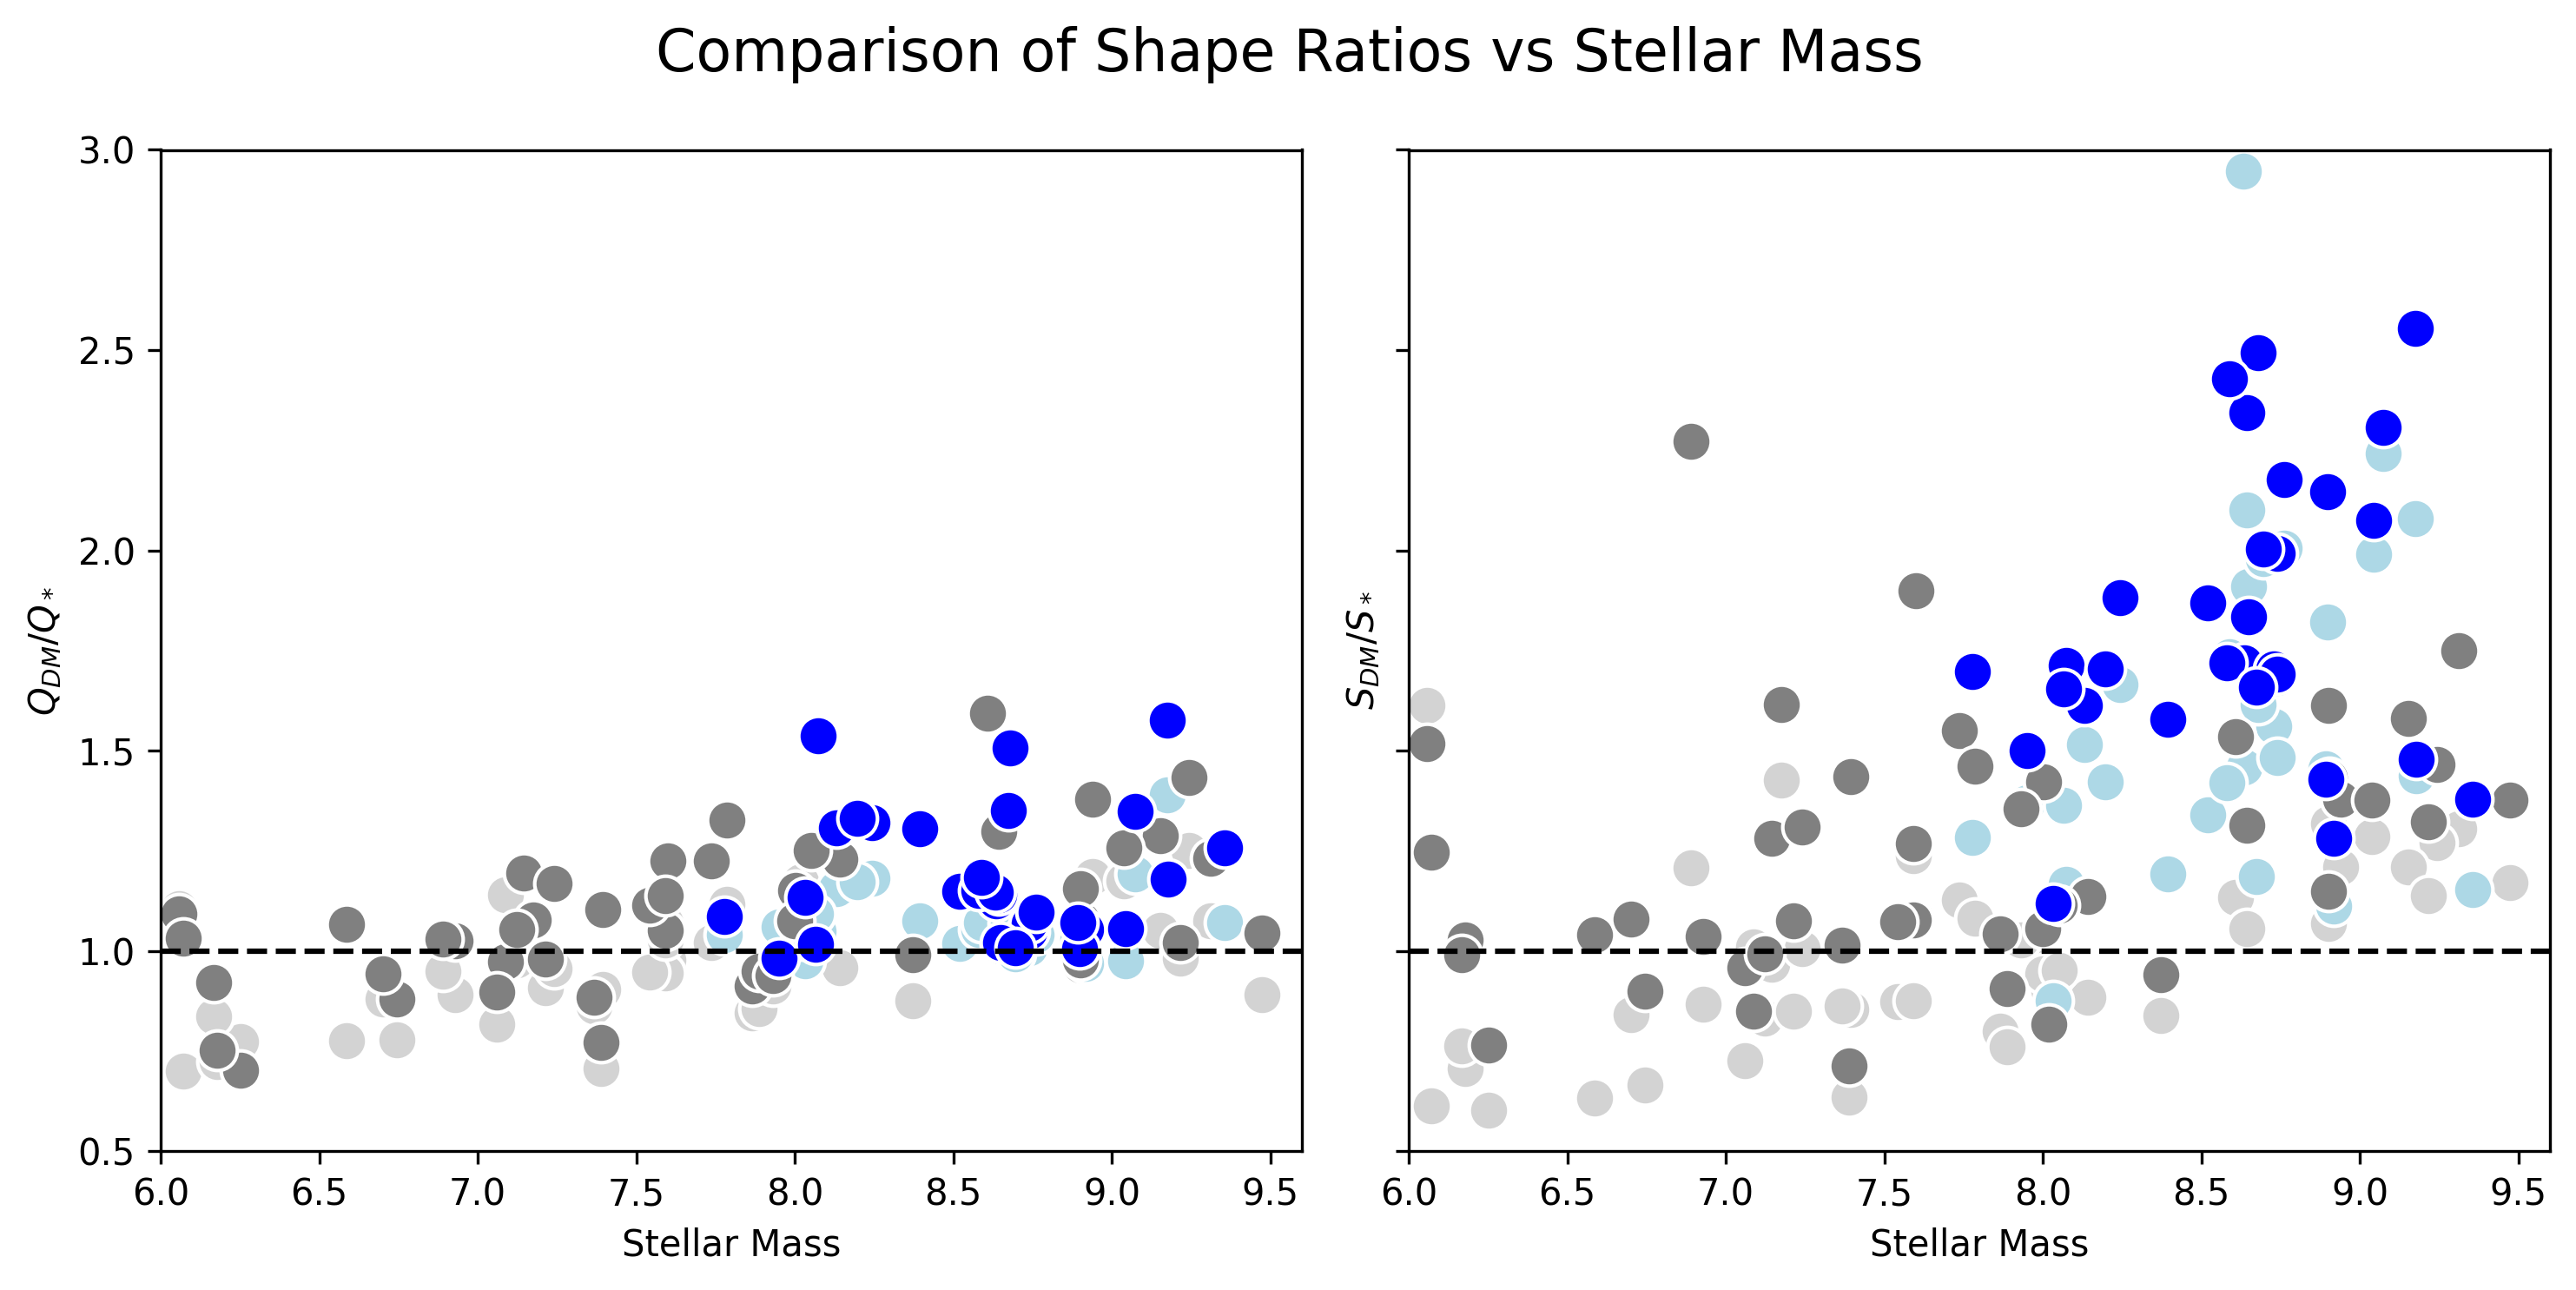

In [28]:

# Create the second plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5),dpi = 300,sharey=True,sharex=True)
fig.suptitle('Comparison of Shape Ratios vs Stellar Mass', fontsize=16)
#remove grid
for a in ax:
    a.grid(False)
    #plot line at y = 1
    a.axhline(1, color='black', linestyle='--')

point_size = 120
# Function to plot data for each dataframe
def plot_data_ratio(ax, data, label, marker, ratio_column):
    for galaxy_class in ['elliptical', 'irregular', 'disk']:
        mask = data['galaxy_class'] == galaxy_class
        color = 'gray' if galaxy_class in ['elliptical', 'irregular'] else 'blue'
        #remove grid



        #lighter color for dfNew
        if label == 'df':
            color = 'light' + color

        ax.scatter(np.log10(data.loc[mask, 'Stellar mass']),
                   data.loc[mask, ratio_column],
                   c=color,
                   label=f'{label} - {galaxy_class}',
                   alpha=1,
                   marker=marker,
                   s=point_size,
                   edgecolors='white')

# Plot B_dm/B_star vs stellar mass
#ax[0].set_title('B_dm/B_star vs Stellar Mass')
ax[0].set_xlabel('Stellar Mass')
ax[0].set_ylabel(r'$Q_{DM}/Q_*$')

plot_data_ratio(ax[0], df_common, 'df', 'o', 'B_dm/B_star')  # Circle for df
plot_data_ratio(ax[0], dfNew_common, 'dfNew', 'o', 'B_dm/B_star')  # Triangle for dfNew

# Plot C_dm/C_star vs stellar mass
#ax[1].set_title('C_dm/C_star vs Stellar Mass')
ax[1].set_xlabel('Stellar Mass')
ax[1].set_ylabel(r'$S_{DM}/S_*$')

plot_data_ratio(ax[1], df_common, 'df', 'o', 'C_dm/C_star')  # Circle for df
plot_data_ratio(ax[1], dfNew_common, 'dfNew', 'o', 'C_dm/C_star')  # Triangle for dfNew

#limit y scale from 0.5 to 3
ax[0].set_ylim(0.5, 3)
#limit x from 6 to 9.6
ax[0].set_xlim(6, 9.6)





# Adjust layout and show legend
plt.tight_layout()
#handles, labels = ax[1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

plt.show()

In [ ]:
# find sims in dfNew that have B_s < 0.6 and print B_s and sims
dfNew[dfNew['B_s'] < 0.6][['B_s', 'sims']]

In [ ]:
tol = 1e-3
for i in range(5):
    tol = tol*5
    print(tol,15*(i+1))

In [28]:
# noinspection JupyterPackage
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def analyze_relationships(df):
    # Remove 'sims' and 'hids' columns
    df = df.drop(['sims', 'hids'], axis=1, errors='ignore')
    
    # Handle 'diffs_at_reff'
    if 'diffs_at_reff' in df.columns:
        for i in range(3):
            df[f'diffs_at_reff_{i}'] = df['diffs_at_reff'].apply(lambda x: x[i])
        df = df.drop('diffs_at_reff', axis=1)
    
    # Separate numerical and categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    results = []
    
    # 1. Correlation analysis for numerical variables
    corr_matrix = df[num_cols].corr()
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.5:  # You can adjust this threshold
                results.append({
                    'test': 'Correlation',
                    'variables': f'{num_cols[i]} vs {num_cols[j]}',
                    'statistic': corr,
                    'interpretation': f"Strong {'positive' if corr > 0 else 'negative'} correlation"
                })
    
    # 2. Mutual Information for numerical vs categorical variables
    le = LabelEncoder()
    for cat_col in cat_cols:
        y = le.fit_transform(df[cat_col])
        mi_scores = mutual_info_regression(df[num_cols], y)
        for i, score in enumerate(mi_scores):
            if score > 0.1:  # You can adjust this threshold
                results.append({
                    'test': 'Mutual Information',
                    'variables': f'{num_cols[i]} vs {cat_col}',
                    'statistic': score,
                    'interpretation': 'Strong relationship'
                })
    
    # 3. ANOVA for numerical variables across categories
    for num_col in num_cols:
        for cat_col in cat_cols:
            groups = [group for _, group in df.groupby(cat_col)[num_col]]
            f_value, p_value = stats.f_oneway(*groups)
            if p_value < 0.05:
                results.append({
                    'test': 'ANOVA',
                    'variables': f'{num_col} across {cat_col}',
                    'statistic': f_value,
                    'p_value': p_value,
                    'interpretation': 'Significant difference between groups'
                })
                
                # Post-hoc Tukey's test
                tukey = pairwise_tukeyhsd(df[num_col], df[cat_col])
                significant_pairs = tukey.reject
                if np.any(significant_pairs):
                    indices = np.where(significant_pairs)
                    if len(indices) == 2:  # Ensure there are two lists of indices
                        pair_labels = [f"{tukey.groupsunique[i]}-{tukey.groupsunique[j]}" 
                                       for i, j in zip(*indices)]
                        results.append({
                            'test': "Tukey's HSD",
                            'variables': f'{num_col} across {cat_col}',
                            'interpretation': f"Significant differences between: {', '.join(pair_labels)}"
                        })
                    
    # 4. Chi-square test for categorical variables
    for i in range(len(cat_cols)):
        for j in range(i+1, len(cat_cols)):
            contingency_table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
            chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
            if p_value < 0.05:
                results.append({
                    'test': 'Chi-square',
                    'variables': f'{cat_cols[i]} vs {cat_cols[j]}',
                    'statistic': chi2,
                    'p_value': p_value,
                    'interpretation': 'Significant relationship'
                })
    
    return pd.DataFrame(results)

# Use the function
significant_relationships = analyze_relationships(df)
print(significant_relationships)

# Optional: Save to CSV
# significant_relationships.to_csv('significant_relationships.csv', index=False)

            test                            variables  statistic  \
0    Correlation                           B_s vs T_s  -0.831665   
1    Correlation                           B_s vs B_d   0.610382   
2    Correlation                           B_s vs T_d  -0.606215   
3    Correlation                          C_s vs reff  -0.715538   
4    Correlation                          C_s vs mvir  -0.502792   
..           ...                                  ...        ...   
102        ANOVA    T_dm - T_star across galaxy_class   3.402663   
103        ANOVA   T_dm - T_star across feedback_type   5.094287   
104        ANOVA  diffs_at_reff_2 across galaxy_class  18.161521   
105   Chi-square        galaxy_class vs feedback_type  18.973419   
106   Chi-square               feedback_type vs htype   9.202015   

                            interpretation       p_value  
0              Strong negative correlation           NaN  
1              Strong positive correlation           NaN  
2     

In [29]:
significant_relationships


,test,variables,statistic,interpretation,p_value
0,Correlation,B_s vs T_s,-0.831665,Strong negative correlation,NaN
1,Correlation,B_s vs B_d,0.610382,Strong positive correlation,NaN
2,Correlation,B_s vs T_d,-0.606215,Strong negative correlation,NaN
3,Correlation,C_s vs reff,-0.715538,Strong negative correlation,NaN
4,Correlation,C_s vs mvir,-0.502792,Strong negative correlation,NaN
...,...,...,...,...,...
102,ANOVA,T_dm - T_star across galaxy_class,3.402663,Significant difference between groups,3.843281e-02
103,ANOVA,T_dm - T_star across feedback_type,5.094287,Significant difference between groups,2.683967e-02
104,ANOVA,diffs_at_reff_2 across galaxy_class,18.161521,Significant difference between groups,3.573550e-07
105,Chi-square,galaxy_class vs feedback_type,18.973419,Significant relationship,7.585331e-05


/tmp/ipykernel_3932844/2612443108.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(title='Galaxy Type')
/tmp/ipykernel_3932844/2612443108.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(title='Galaxy Type')
/tmp/ipykernel_3932844/2612443108.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(title='Galaxy Type')
/tmp/ipykernel_3932844/2612443108.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(title='Galaxy Type')
/tmp

Text(0.5, 1.0, 'C_s vs reff, colored by mvir')

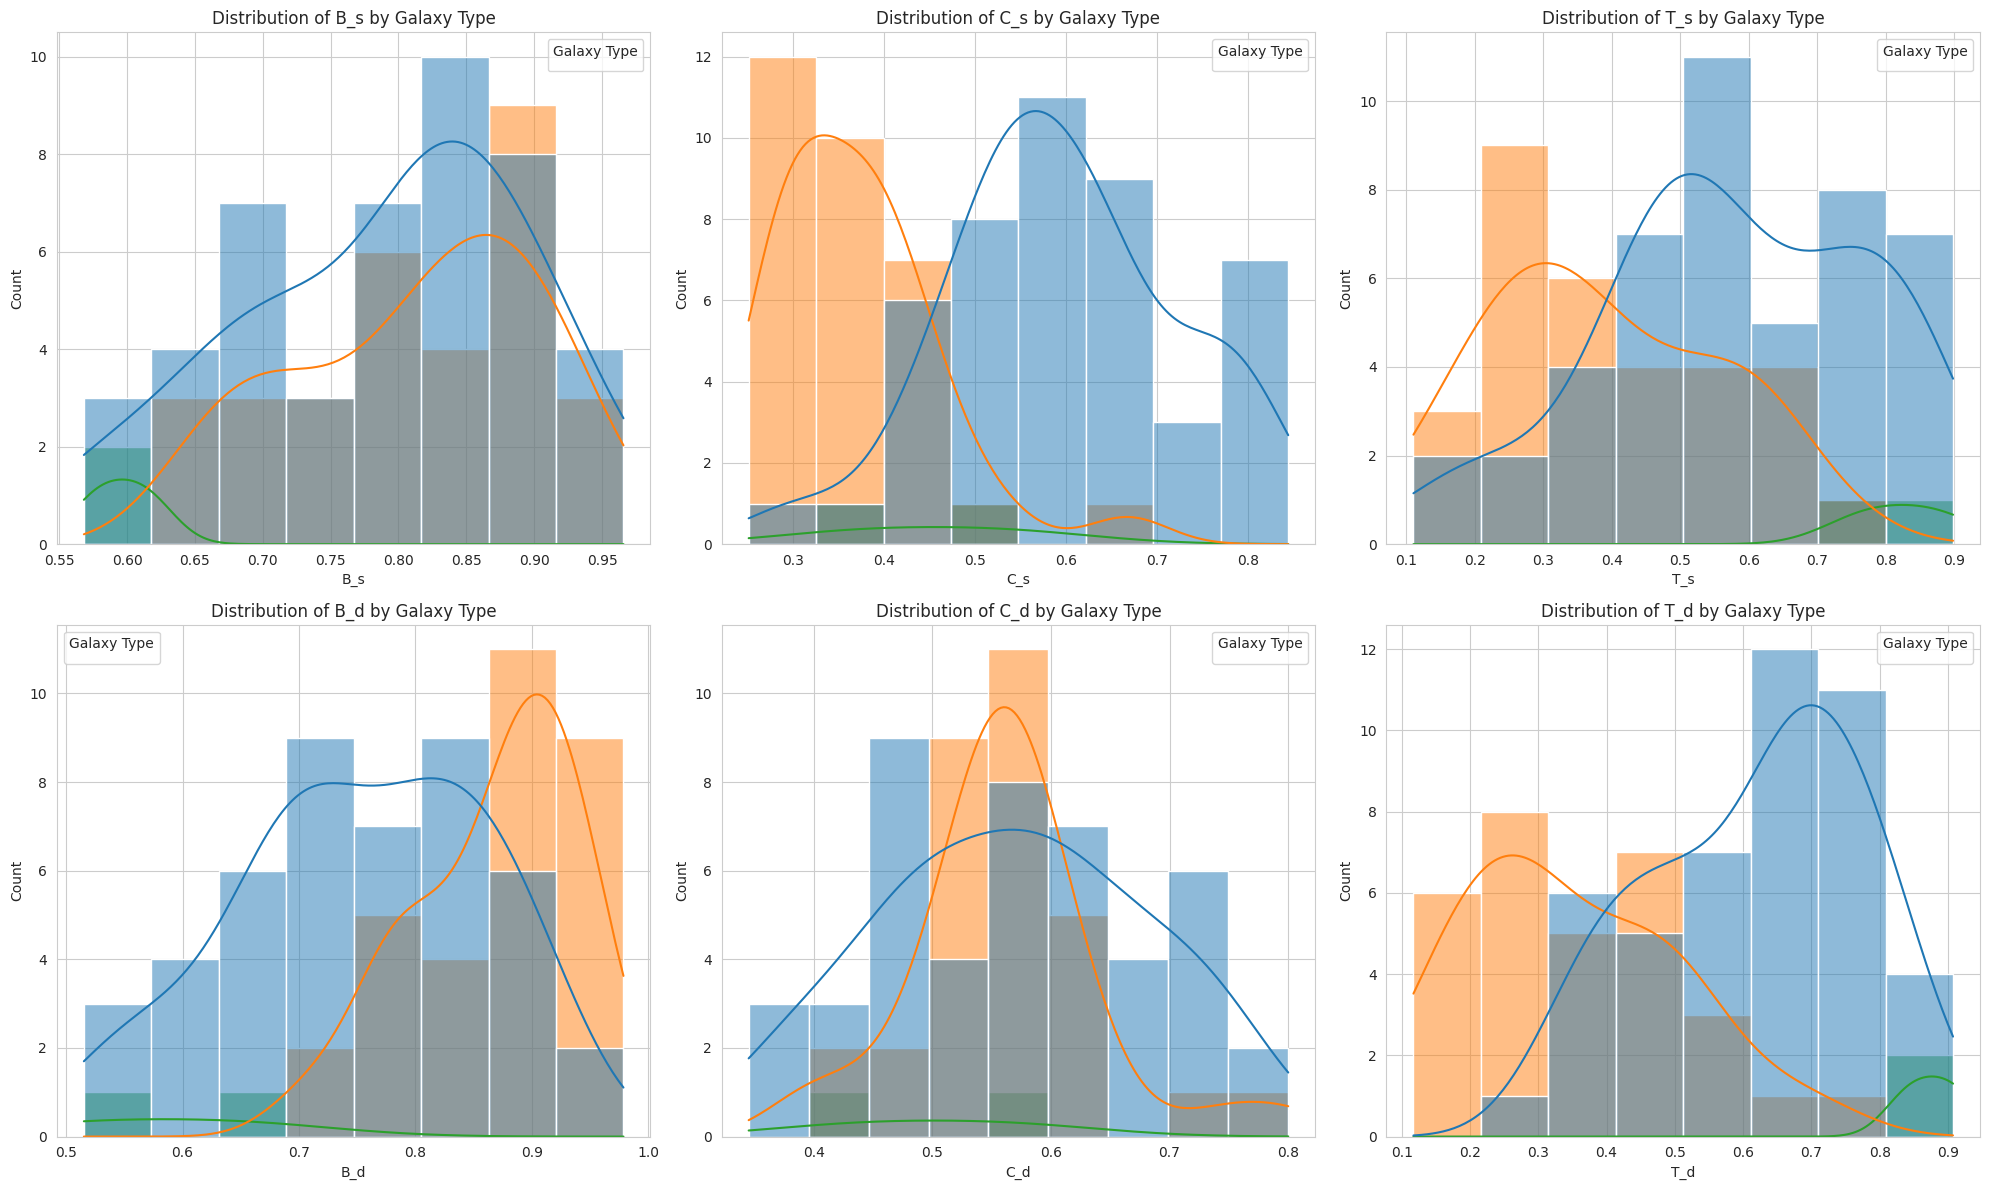

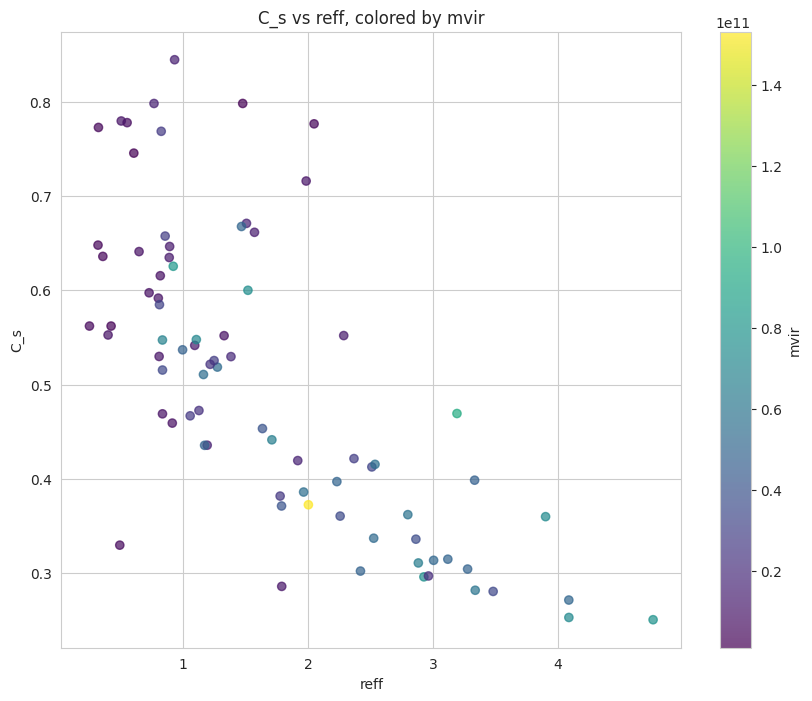

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Assuming your dataframe is called 'df'

# Set the style for all plots


# 1. Histograms for shape parameters by galaxy type
shape_params = ['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, param in enumerate(shape_params):
    sns.histplot(data=df, x=param, hue='galaxy_class', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {param} by Galaxy Type')
    axes[i].legend(title='Galaxy Type')

plt.tight_layout()
# plt.savefig('shape_param_distributions.png')
# plt.close()


# 4. Scatter plot: C_s vs reff, colored by mvir

# plt.savefig('C_s_vs_reff_mvir.png')
# plt.close()

# 5. Boxplot: C_dm/C_star by galaxy_class
# plt.figure(figsize=(10, 8))
# sns.boxplot(data=df, x='galaxy_class', y='C_dm/C_star')
# plt.title('Distribution of C_dm/C_star by Galaxy Type')
# plt.savefig('C_dm_C_star_by_galaxy_type.png')
# plt.close()

# 6. Scatter plot: mb vs mvir, colored by galaxy_class
# plt.figure(figsize=(10, 8))
# sns.scatterplot(data=df, x='mb', y='mvir', hue='galaxy_class')
# plt.title('Relationship between mb and mvir')
# plt.savefig('mb_vs_mvir.png')
# plt.close()

# 7. Pairplot for shape parameters
# shape_params = ['B_s', 'C_s', 'T_s', 'B_d', 'C_d', 'T_d']
# sns.pairplot(df[shape_params + ['galaxy_class']], hue='galaxy_class', corner=True)
# plt.savefig('shape_param_pairplot.png')
# plt.close()

# # 8. Correlation heatmap for shape parameters
# corr_matrix = df[shape_params].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Correlation Heatmap of Shape Parameters')
# # plt.savefig('shape_param_correlation_heatmap.png')
# # plt.close()

#print("All plots have been saved as PNG files in your current directory.")

Text(0.5, 1.0, 'C_s vs reff, colored by mvir')

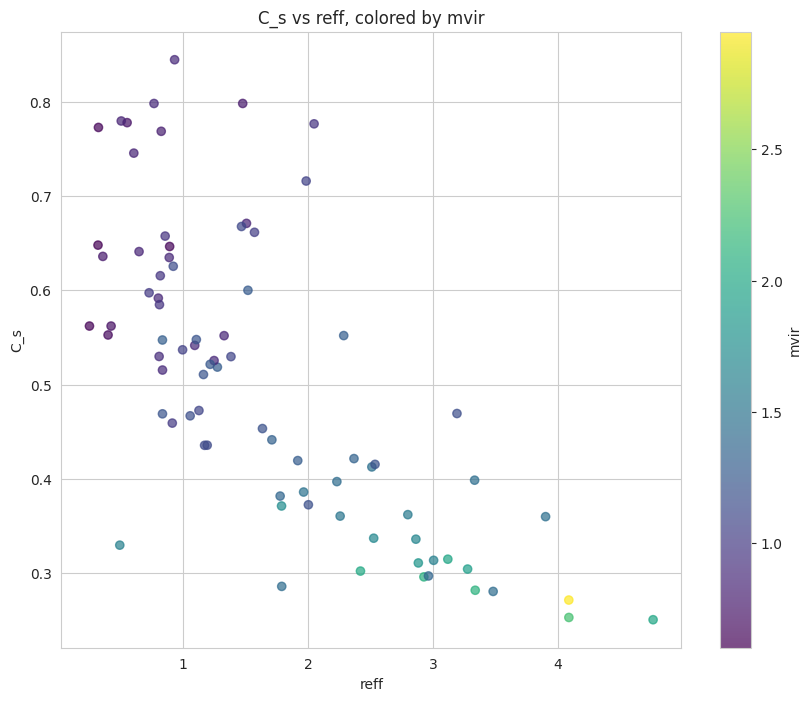

In [45]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['reff'], df['C_s'], c=df['C_dm/C_star'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='mvir')
plt.ylabel('C_s')
plt.xlabel('reff')
plt.title('C_s vs reff, colored by mvir')




Text(0.5, 0, 'C_dm/C_star')

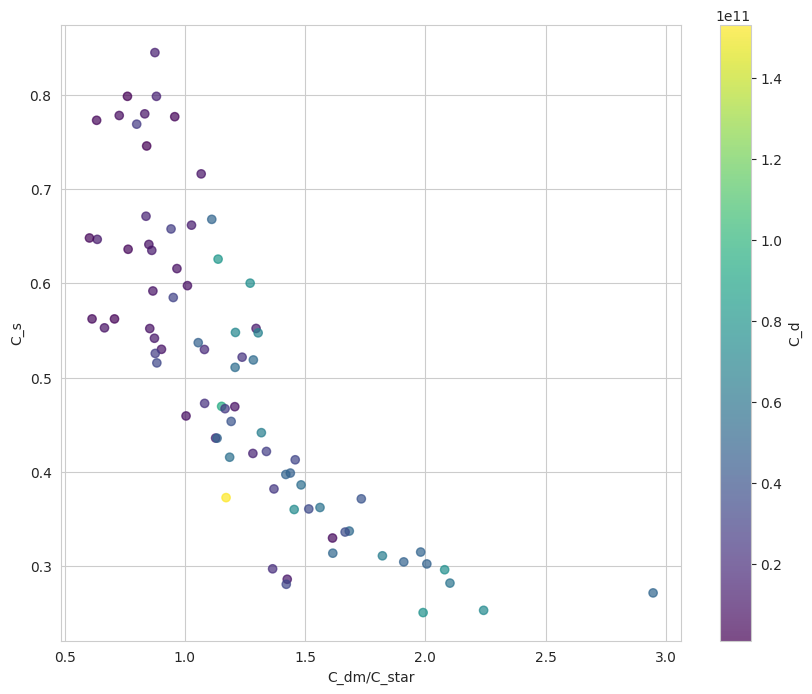

In [52]:
#plot   c_s vs c_dm/c_star
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['C_dm/C_star'], df['C_s'], c=df['mvir'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='C_d')
plt.ylabel('C_s')
plt.xlabel('C_dm/C_star')


Text(0, 0.5, 'C_s')

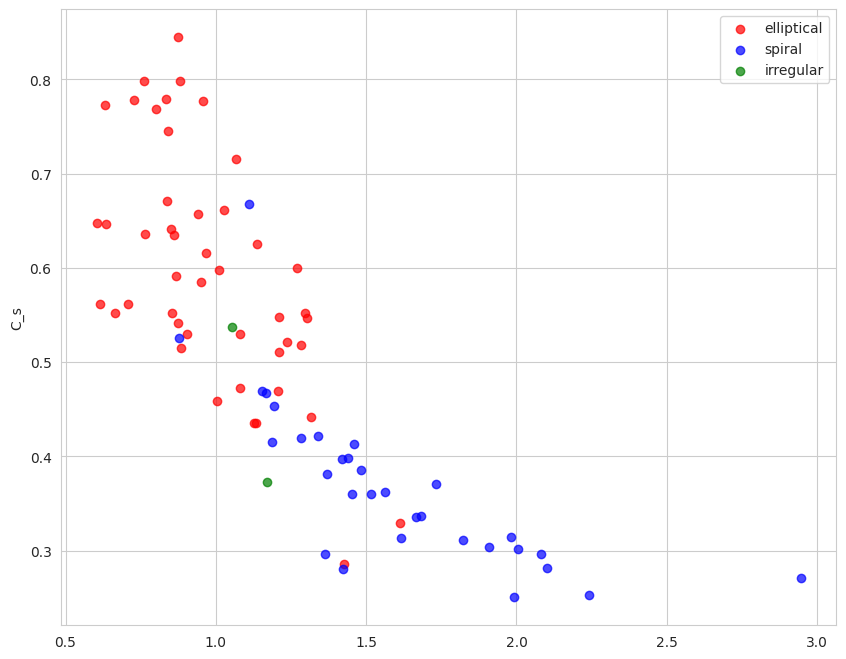

In [58]:
#plot   c_s vs c_dm/c_star colored by galaxy_class
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['C_dm/C_star'][df['galaxy_class'] == 'elliptical'], df['C_s'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7)
scatter = plt.scatter(df['C_dm/C_star'][df['galaxy_class'] == 'disk'], df['C_s'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7)
scatter = plt.scatter(df['C_dm/C_star'][df['galaxy_class'] == 'irregular'], df['C_s'][df['galaxy_class'] == 'irregular'], c='green', alpha=0.7)
plt.legend(['elliptical', 'spiral', 'irregular'])
plt.ylabel('C_s')


(-0.05, 1.05, -0.05, 1.05)

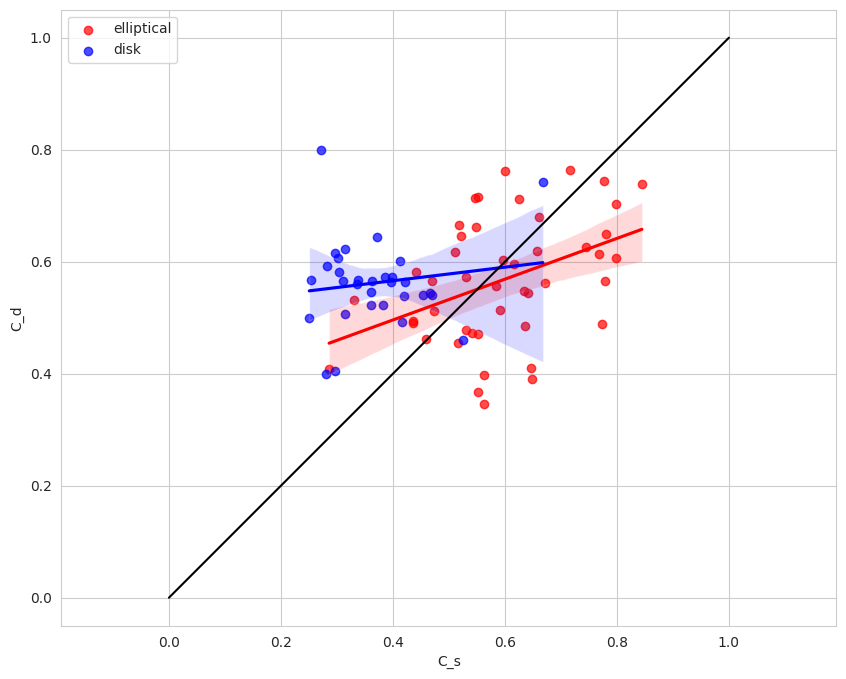

In [104]:
#plot c_d vs c_s colored by galaxy_class

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['C_s'][df['galaxy_class'] == 'elliptical'], df['C_d'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7)
scatter = plt.scatter(df['C_s'][df['galaxy_class'] == 'disk'], df['C_d'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7)
#fit lines by galaxy_class using sns
sns.regplot(x=df['C_s'][df['galaxy_class'] == 'elliptical'], y=df['C_d'][df['galaxy_class'] == 'elliptical'], scatter=False, color='red')
sns.regplot(x=df['C_s'][df['galaxy_class'] == 'disk'], y=df['C_d'][df['galaxy_class'] == 'disk'], scatter=False, color='blue')
plt.legend(['elliptical', 'disk'])

plt.plot([0,1], [0,1], c='black')
#equal aspect ratio
plt.axis('equal')

In [ ]:
#plot histogram of mb colored by galaxy_class
plt.figure(figsize=(10, 8))
mbs = ['mb','mb_reff','mb_10rvir']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, mb in enumerate(mbs):
    #create log bins for mb
    bins = np.logspace(np.log10(df[mb].min()), np.log10(df[mb].max()), 15)
    bins = np.linspace(df[mb].min(), df[mb].max(), 15)
    # Plot histograms for each galaxy type outline only
    ax[i].hist(df[mb][df['galaxy_class'] == 'elliptical'], bins=bins, color='red', alpha=0.5, edgecolor='black',label = 'elliptical',density=True)
    ax[i].hist(df[mb][df['galaxy_class'] == 'disk'], bins=bins, color='blue', alpha=0.5, edgecolor='black',label = 'disk',density=True)
    ax[i].set_title(f'Distribution of {mb} by Galaxy Type')
    ax[i].legend(title='Galaxy Type')
    #ax[i].set_xscale('log')
    

#plot histogram of mb colored by galaxy_class
plt.figure(figsize=(10, 8))
mbs = ['mb','mb_reff','mb_10rvir']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, mb in enumerate(mbs):
    #create log bins for mb
    #bins = np.logspace(np.log10(df[mb].min()), np.log10(df[mb].max()), 15)
    bins = np.linspace(df[mb].min(), df[mb].max(), 15)
    # Plot histograms for each galaxy type outline only
    ax[i].hist(df[mb][df['feedback_type'] == 'MerianCDM'], bins=bins, color='red', alpha=0.5, edgecolor='black',label = 'MerianCDM',density=True)
    ax[i].hist(df[mb][df['feedback_type'] == 'BWMDC'], bins=bins, color='blue', alpha=0.5, edgecolor='black',label = 'BWMDC',density=True)
    ax[i].set_title(f'Distribution of {mb} by Galaxy Type')
    ax[i].legend(title='Galaxy Type')
    #ax[i].set_xscale('log')

<Figure size 1000x800 with 0 Axes>

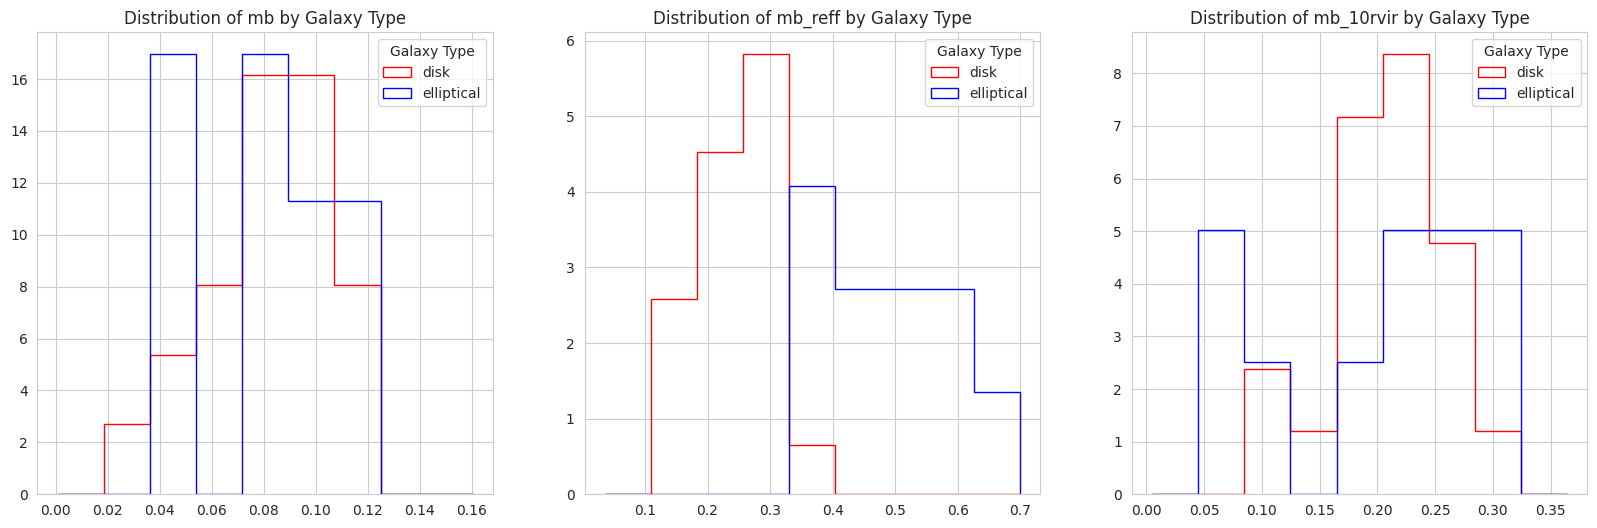

<Figure size 1000x800 with 0 Axes>

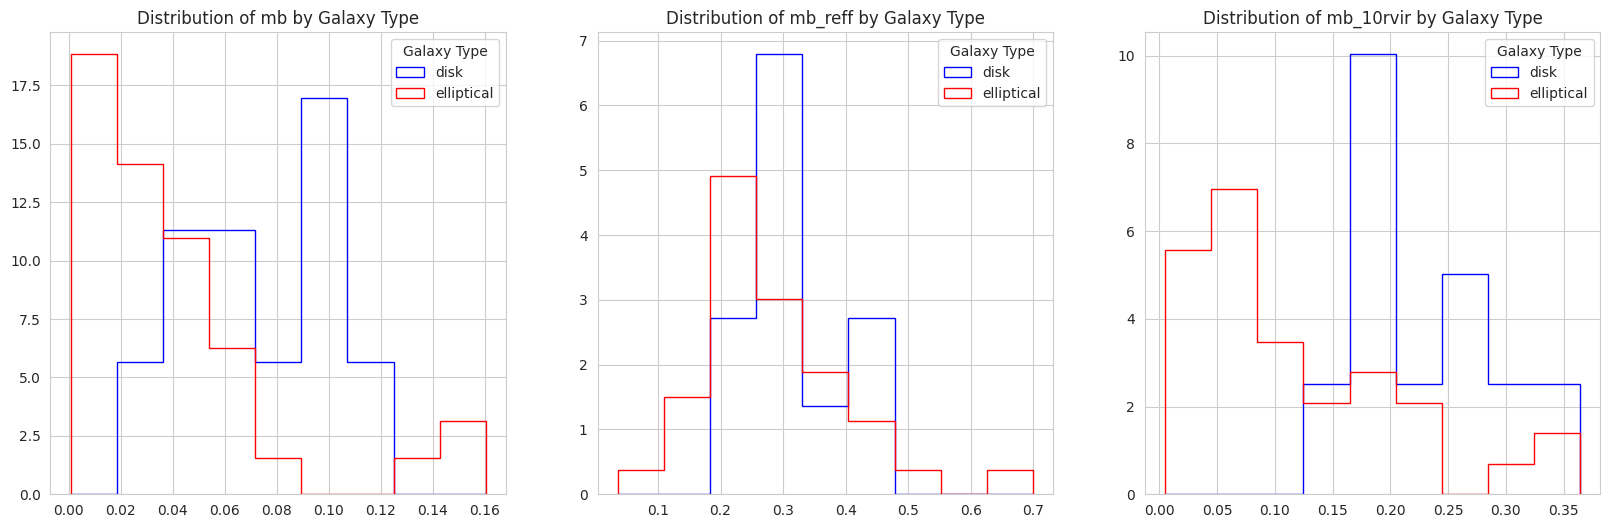

In [134]:


#create seperate histograms for each feedback type and galaxy class
plt.figure(figsize=(10, 8))
mbs = ['mb','mb_reff','mb_10rvir']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, mb in enumerate(mbs):
    #create log bins for mb
    bins = np.linspace(df[mb].min(), df[mb].max(), 10)
    # Plot histograms for each galaxy type outline only
    ax[i].hist(df[mb][(df['feedback_type'] == 'MerianCDM') & (df['galaxy_class'] == 'disk')], bins=bins, color='blue', alpha=1, edgecolor='red',label = 'disk',density=True,histtype='step')
    ax[i].hist(df[mb][(df['feedback_type'] == 'MerianCDM') & (df['galaxy_class'] == 'elliptical')], bins=bins, color='red', alpha=1, edgecolor='blue',label = 'elliptical',density=True,histtype='step')
    ax[i].set_title(f'Distribution of {mb} by Galaxy Type')
    ax[i].legend(title='Galaxy Type')
    #ax[i].set_xscale('log')
    
plt.figure(figsize=(10, 8))
mbs = ['mb','mb_reff','mb_10rvir']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, mb in enumerate(mbs):
    #create log bins for mb
    bins = np.linspace(df[mb].min(), df[mb].max(), 10)
    # Plot histograms for each galaxy type outline only
    ax[i].hist(df[mb][(df['feedback_type'] == 'BWMDC') & (df['galaxy_class'] == 'disk')], bins=bins, color='blue', alpha=1, edgecolor='blue',label = 'disk',density=True,histtype='step')
    ax[i].hist(df[mb][(df['feedback_type'] == 'BWMDC') & (df['galaxy_class'] == 'elliptical')], bins=bins, color='red', alpha=1, edgecolor='red',label = 'elliptical',density=True,histtype='step')
    ax[i].set_title(f'Distribution of {mb} by Galaxy Type')
    ax[i].legend(title='Galaxy Type')

In [ ]:
#plot c_d vs mb_reff colored by galaxy_class
plt.figure(figsize=(10, 8))
plt.scatter(df['C_d'][df['galaxy_class'] == 'elliptical'], df['mb_reff'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7, label = 'elliptical')
plt.scatter(df['C_d'][df['galaxy_class'] == 'disk'], df['mb_reff'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7, label = 'disk')
#add sns.regplots
sns.regplot(x=df['C_d'][df['galaxy_class'] == 'elliptical'], y=df['mb_reff'][df['galaxy_class'] == 'elliptical'], scatter=False, color='red')
sns.regplot(x=df['C_d'][df['galaxy_class'] == 'disk'], y=df['mb_reff'][df['galaxy_class'] == 'disk'], scatter=False, color='blue')

plt.legend()
plt.ylabel('C_d')
plt.xlabel('mb_reff')

Text(0.5, 0, 'Stellar mass')

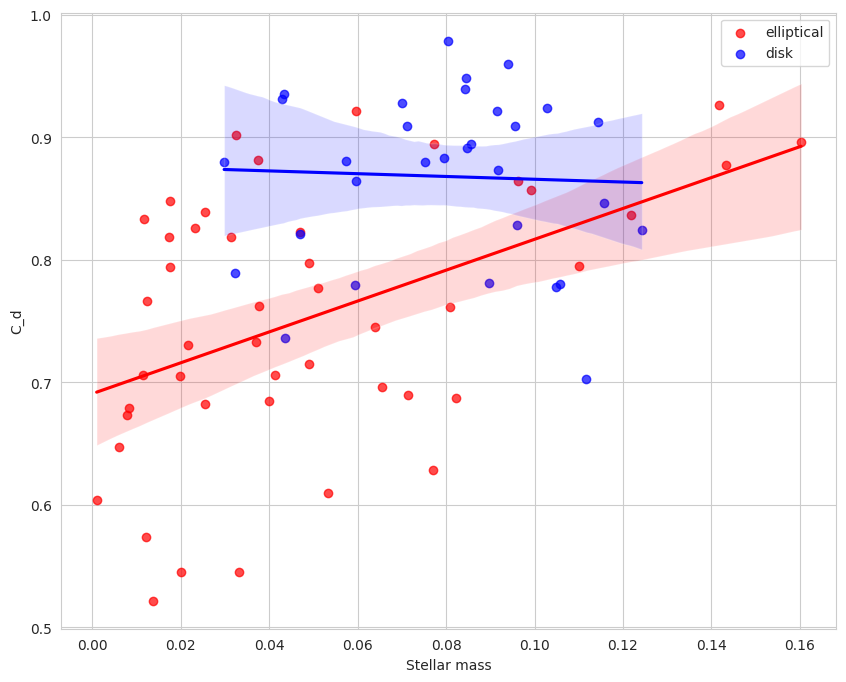

In [116]:

#plot c_d vs mb_reff colored by galaxy_class
plt.figure(figsize=(10, 8))
plt.scatter(df['mb'][df['galaxy_class'] == 'elliptical'], df['B_d'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7, label = 'elliptical')
plt.scatter(df['mb'][df['galaxy_class'] == 'disk'], df['B_d'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7, label = 'disk')
#add sns.regplots
sns.regplot(x=df['mb'][df['galaxy_class'] == 'elliptical'], y=df['B_d'][df['galaxy_class'] == 'elliptical'], scatter=False, color='red')
sns.regplot(x=df['mb'][df['galaxy_class'] == 'disk'], y=df['B_d'][df['galaxy_class'] == 'disk'], scatter=False, color='blue')
#plt.xscale('log')
plt.legend()
plt.ylabel('C_d')
plt.xlabel('Stellar mass')

(0.22097447700723263,
 0.8743069964258378,
 0.32233787088091853,
 0.8228810190939646)

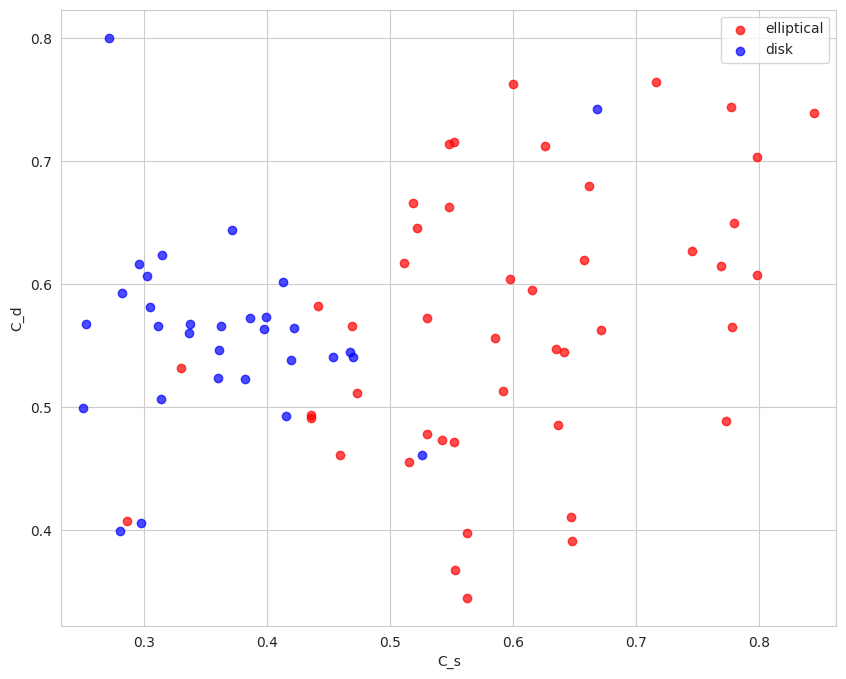

In [103]:

#plot c_s vs c_d colored by galaxy_class
plt.figure(figsize=(10, 8))
plt.scatter(df['C_s'][df['galaxy_class'] == 'elliptical'], df['C_d'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7, label = 'elliptical')
plt.scatter(df['C_s'][df['galaxy_class'] == 'disk'], df['C_d'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7, label = 'disk')
plt.legend()
plt.ylabel('C_d')
plt.xlabel('C_s')
#set aspect ratio to be equal

plt.axis('equal')




(0.0, 1.0)

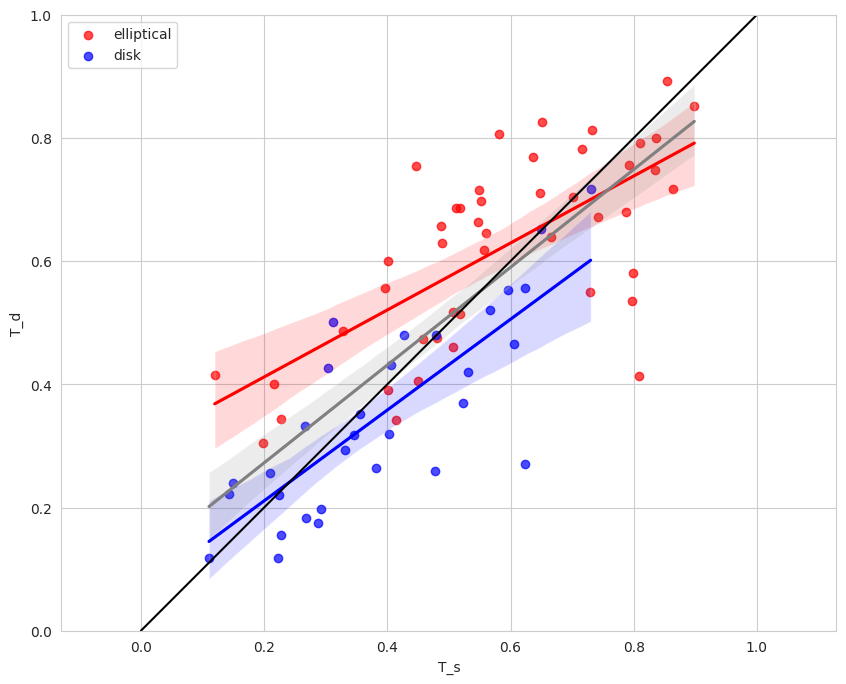

In [141]:
#T_s vs T_d colored by galaxy_class
plt.figure(figsize=(10, 8))
plt.scatter(df['T_s'][df['galaxy_class'] == 'elliptical'], df['T_d'][df['galaxy_class'] == 'elliptical'], c='red', alpha=0.7, label = 'elliptical')
plt.scatter(df['T_s'][df['galaxy_class'] == 'disk'], df['T_d'][df['galaxy_class'] == 'disk'], c='blue', alpha=0.7, label = 'disk')
sns.regplot(x=df['T_s'][df['galaxy_class'] == 'elliptical'], y=df['T_d'][df['galaxy_class'] == 'elliptical'], scatter=False, color='red')
sns.regplot(x=df['T_s'][df['galaxy_class'] == 'disk'], y=df['T_d'][df['galaxy_class'] == 'disk'], scatter=False, color='blue')
sns.regplot(x=df['T_s'], y=df['T_d'], scatter=False, color='gray')
plt.legend()
plt.plot([0,1], [0,1], c='black')
plt.axis('equal')
plt.ylabel('T_d')
plt.xlabel('T_s')
plt.xlim(0,1)
plt.ylim(0,1)


(0.3776718850948465, 3.0688904130082237, 0.45, 1.55)

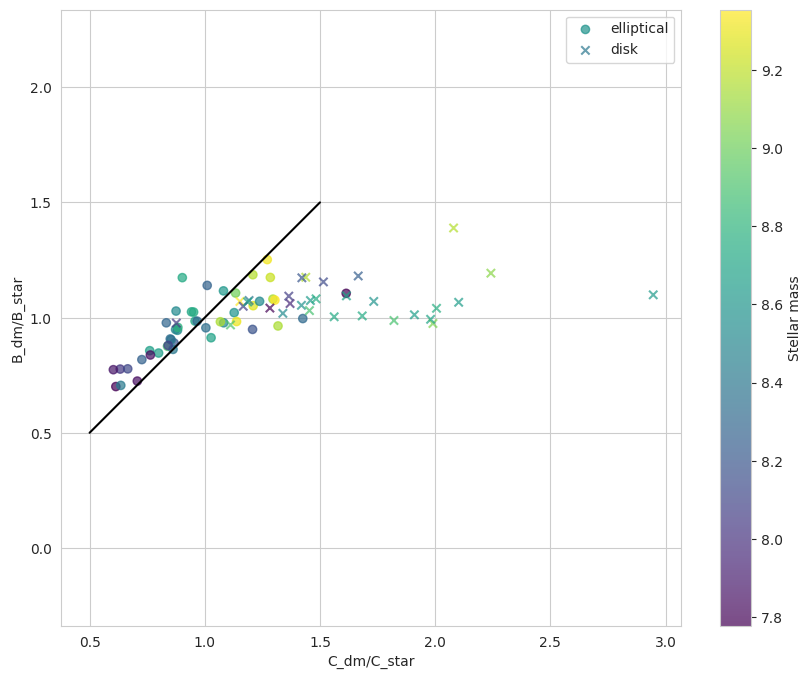

In [155]:
#plot c_dm/c_star vs b_dm/b_star markers by galaxy_class, colored by stellar mass
plt.figure(figsize=(10, 8))
plt.scatter(df['C_dm/C_star'][df['galaxy_class'] == 'elliptical'], df['B_dm/B_star'][df['galaxy_class'] == 'elliptical'], marker='o', c=np.log10(df['Stellar mass'][df['galaxy_class'] == 'elliptical']), cmap='viridis', alpha=0.7, label = 'elliptical')
plt.scatter(df['C_dm/C_star'][df['galaxy_class'] == 'disk'], df['B_dm/B_star'][df['galaxy_class'] == 'disk'], marker='x', c=np.log10(df['Stellar mass'][df['galaxy_class'] == 'disk']), cmap='viridis', alpha=0.7, label = 'disk')
plt.plot([0.5,1.5], [0.5,1.5], c='black')
plt.colorbar(label='Stellar mass')
plt.legend()
plt.ylabel('B_dm/B_star')
plt.xlabel('C_dm/C_star')
plt.axis('equal')
